# Détermination des trajectoires similaires

In [1]:
%matplotlib inline
from nuscenes.nuscenes import NuScenes
nusc = NuScenes(version='v1.0-mini', dataroot='/Users/tiffanydarini/nuscenes-devkit/python-sdk/tutorials/data/sets/nuscenes/v1.0-mini', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.343 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


### Fonction utiles et imports nécessaires

In [2]:
# Fonction qui renvoie les tables ego_pose d'une scène donnée
def get_poses(scene_token):
    pose_list = []
    scene_rec = nusc.get('scene', scene_token)
    sample_rec = nusc.get('sample', scene_rec['first_sample_token'])
    sd_rec = nusc.get('sample_data', sample_rec['data']['LIDAR_TOP'])
    
    ego_pose = nusc.get('ego_pose', sd_rec['token'])
    pose_list.append(ego_pose)

    while sd_rec['next'] != '':
        sd_rec = nusc.get('sample_data', sd_rec['next'])
        ego_pose = nusc.get('ego_pose', sd_rec['token'])
        pose_list.append(ego_pose)

    return pose_list

In [3]:
# On crée une fonction qui renvoie la liste des rangs dans les listes X,Y des objets immobiles de 
# cette liste et donc d'une même catégorie, ainsi que la liste des objets mobiles 
from math import sqrt

def immobile(X,Y):
    Immo = []
    Mobile = []
    n = len(X) # Nombre d'élément dans la catégorie 
    for i in range(0,n-1):
        X_coord = X[i]
        Y_coord = Y[i]
        if len(X_coord)==1 :
            Immo.append(i)
        else : 
            d = 0 
            for k in range(0,len(X_coord)-1):
                d+= sqrt((X_coord[k+1]-X_coord[k])**2+(Y_coord[k+1]-Y_coord[k])**2)
            if d<2 : # Si la distance totale parcourue par l'objet est inférieur à 2m, on considère que l'objet bouge pas
                Immo.append(i)
            else :
                Mobile.append(i)
    return Immo,Mobile  

In [4]:
from dtw import *
import matplotlib.pyplot as plt
from datetime import timedelta

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [5]:
import numpy as np 
from math import sqrt 

# Fonction qui renvoie la matrice des distances 
def Matrice_distance(X_ego,Y_ego,X_veh,Y_veh):
    M = np.zeros((len(X_veh),len(X_ego)))
    for i in range(0,len(X_veh)):
        for j in range(0,len(X_ego)):
            #M[i,j] = sqrt((X_veh[len(X_veh)-1-i]-X_ego[j])**2+(Y_veh[len(Y_veh)-1-i]-Y_ego[j])**2)
            M[i,j] = sqrt((X_veh[i]-X_ego[j])**2+(Y_veh[i]-Y_ego[j])**2)
    return M 
     

In [6]:
import numpy as np 
from math import sqrt 

# Fonction qui renvoie la matrice des distances entre 
# les pts qui interagissent dans le temps 

def M_distance_time(X_ego,Y_ego,T_ego,X_veh,Y_veh,T_veh):
    
    debut = max(T_ego[0],T_veh[0]) # Temps début detection vehicule 1 
    fin = min(T_ego[len(T_ego)-1],T_veh[len(T_veh)-1]) # Temps fin detection vehicule 1 

    # On va créer la liste des indices des élements du veh 1 qui sont en même temps que le veh 2
    L_indice_ego = []
    for k in range(0,len(T_ego)):
        if debut<=T_ego[k]<=fin:
            L_indice_ego.append(k)
            
    # Pareil pour le veh 
    L_indice_veh = []
    for k in range(0,len(T_veh)):
        if debut<=T_veh[k]<=fin:
            L_indice_veh.append(k)
    
    M = np.zeros((len(L_indice_veh),len(L_indice_ego)))
    for i in range(0,len(L_indice_veh)):
        for j in range(0,len(L_indice_ego)):
            M[i,j] = sqrt((X_veh[L_indice_veh[i]]-X_ego[L_indice_ego[j]])**2+(Y_veh[L_indice_veh[i]]-Y_ego[L_indice_ego[j]])**2)
    
    return M 

In [7]:
# Pour normaliser le calcul de DTW, on va créer une fonction qui calcule
# la distance parcourue par un véhicule au cours de la scène, en prenant
# en entrée ses coordonnées

def distance_parcourue(X,Y,Z):
    D =[0]
    for k in range(0,len(X)-1):
        d = D[k]+ sqrt((X[k+1]-X[k])**2+(Y[k+1]-Y[k])**2+(Z[k+1]-Z[k])**2)
        D.append(d)
    return D[len(D)-1]

#### Fenêtre glissante

In [8]:
## Fonction qui renvoie une dataframe avec les valeurs de dtw calculés sur des intervalles de temps d'une seconde : 

#imports nécessaires
import matplotlib.pyplot as plt
from math import sqrt
import datetime 
from datetime import timedelta
from dtw import *
import pandas as pd

def dtw_glissante(scene_name):
    
    # On crée une dataframe 
    df = pd.DataFrame()
    L_intervalle = [[k,k+1] for k in range(0,20)]
    df['index']= L_intervalle
    df.set_index('index',inplace=True)
    df.index.name = None
    
    scene_token = nusc.field2token('scene','name',scene_name)[0]
    sample_token = nusc.field2token('sample','scene_token',scene_token)# Ensemble des token des échantillons de la scene 
    
    # Pour tracer la trajectoire du véhicule ego
    Liste_ego_poses = get_poses(scene_token) 
    X_coord =[]
    Y_coord =[]
    Z_coord =[]
    T_timestamp = [] # liste des timestamps
    for k in range(0,len(Liste_ego_poses)):
        X_coord.append(Liste_ego_poses[k]['translation'][0])
        Y_coord.append(Liste_ego_poses[k]['translation'][1])
        Z_coord.append(Liste_ego_poses[k]['translation'][2])
        T_timestamp.append(Liste_ego_poses[k]['timestamp'])
        
    # Ensemble des sample_annotation de la scène :
    sample_annotation_token = []
    for k in sample_token : 
        L = nusc.field2token('sample_annotation','sample_token',k)
        sample_annotation_token = sample_annotation_token + L
    
    # On créé la liste des token des instances présents dans les sample_annotation
    L_instance_token = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_instance_token.append(exemple['instance_token'])
    # Puisque pour un même objet, on peut avoir plusieurs annotations, on supprime les doublons de L
    L_instance_token = list(set(L_instance_token))
    
    # Liste des catégories d'objet dans la scène 
    L_category_name = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_category_name.append(exemple['category_name'])
    L_category_name = list(set(L_category_name)) #on supprime les doublons 
   
    L_vehicule = ['vehicle.bicycle','vehicle.bus.bendy','vehicle.bus.rigid','vehicle.car','vehicle.construction','vehicle.emergency.ambulance','vehicle.emergency.police','vehicle.motorcycle','vehicle.trailer','vehicle.truck']
    
    L_category_name = [k for k in L_category_name if k in L_vehicule]
    
    # Boucle sur chaque catégorie trouvée
    for j in range(0,len(L_category_name)):   
        catego_name = L_category_name[j]
        catego_token = nusc.field2token('category','name',catego_name)
        category = nusc.get('category',catego_token[0])

        # Ensemble des instances appartenant à la fois à la scène et à la catégorie
        L_instance_category = nusc.field2token('instance','category_token',catego_token[0]) # instance dans la catégorie
        L_instance_category = [x for x in L_instance_category if x in L_instance_token]# et dans la scène 
        L_instance_category
        
        # Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
        # les token des sample_annotation pour un élément de cette catégorie. 

        L=[]
        for k in L_instance_category : 
            instance_category = nusc.get('instance',k)
            nbr_annotations = instance_category['nbr_annotations']
            if nbr_annotations == 1:
                L.append([instance_category['first_annotation_token']])
            else : 
                H = []
                first_token = instance_category['first_annotation_token']
                last_token = instance_category['last_annotation_token']
                current_token = first_token 
        
                s = 0 
                while s!= nbr_annotations :
                    current_ann = nusc.get('sample_annotation', current_token)
                    H.append(current_ann['token'])
                    current_token = current_ann['next'] #On passe au suivant
                    s+=1
                L.append(H)
        
        # Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
        # on va pouvoir récupérer leurs positions et tracer leurs trajectoires

        X = []
        Y = []
        Z = []
        T_time = []
        for k in L :
            x = []
            y = []
            z = []
            t=[]
            for j in k :
                sample_annotation = nusc.get('sample_annotation',j)
                x.append(sample_annotation['translation'][0])
                y.append(sample_annotation['translation'][1])
                z.append(sample_annotation['translation'][2])
                t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
            X.append(x)
            Y.append(y)
            Z.append(z)
            T_time.append(t)
    
        # On crée les listes des objets immobiles et mobiles de la catégorie
        Immo, Mobile = immobile(X,Y)
        
        # On conserve uniquement les objets mobiles 
        X_mobile=[X[i] for i in Mobile]
        Y_mobile=[Y[i] for i in Mobile]
        Z_mobile=[Z[i] for i in Mobile]
        T_mobile = [T_time[i] for i in Mobile]
        
        if len(X_mobile)>0:
        
            for i in range(0,len(X_mobile)):
            
                L_df = []
                # On fait une boucle sur les intervalles de temps 
                for k in range(0,20):
                    current_intervalle = [k,k+1]
                    # On crée les listes des coordonnées qu'on va garder ie qui sont dans l'intervalle de temps ci-dessus
                    Lx_pt_veh = []
                    Ly_pt_veh = []
                    Lt_pt_veh = []
                    Lx_pt_ego = []
                    Ly_pt_ego = []
                    Lt_pt_ego = []
                
                    # On remplit avec les pts du véhicule dont le timestamp est dans l'intervalle 
                    for s in range(len(X_mobile[i])):
                        tveh = (datetime.datetime.fromtimestamp(T_mobile[i][s]/1e6)-datetime.datetime.fromtimestamp(T_timestamp[0]/ 1e6)).total_seconds()
                        if tveh <= current_intervalle[1] and tveh >= current_intervalle[0] :
                            Lx_pt_veh.append(X_mobile[i][s])
                            Ly_pt_veh.append(Y_mobile[i][s])
                            Lt_pt_veh.append(T_mobile[i][s])
                    
                
                
                    # On remplit avec les pts du véhicule ego dont le timestamp est dans l'intervalle 
                    for s in range(len(X_coord)):
                        tego = (datetime.datetime.fromtimestamp(T_timestamp[s]/1e6)-datetime.datetime.fromtimestamp(T_timestamp[0]/ 1e6)).total_seconds()
                        if tego <= current_intervalle[1] and tego >= current_intervalle[0]:
                            Lx_pt_ego.append(X_coord[s])
                            Ly_pt_ego.append(Y_coord[s])
                            Lt_pt_ego.append(T_timestamp[s])
                
                            
                    if len(Lx_pt_veh)==0:
                        L_df.append(np.nan)
                    else :
                        #M_distance = M_distance_time(Lx_pt_ego,Ly_pt_ego,Lt_pt_ego,Lx_pt_veh,Ly_pt_veh,Lt_pt_veh)
                        M_distance = Matrice_distance(Lx_pt_ego,Ly_pt_ego,Lx_pt_veh,Ly_pt_veh)
                        alignment = dtw(M_distance)
                        distance = alignment.normalizedDistance
                        L_df.append(distance) 


                nom = catego_name +' '+str(i+1)
                df[nom]= L_df
    
    return df

#M_distance_time(X_coord,Y_coord,T_timestamp,X_mobile[i],Y_mobile[i],T_mobile[i])

In [9]:
scene_name = 'scene-0061'
df_glissante = dtw_glissante(scene_name)
df_glissante

,vehicle.car 1,vehicle.car 2,vehicle.car 3,vehicle.car 4,vehicle.car 5,vehicle.bus.rigid 1,vehicle.truck 1
"[0, 1]",24.142933,30.496933,35.404644,32.984968,72.845804,55.787752,40.799903
"[1, 2]",40.586937,23.331444,38.301036,29.549825,68.295421,73.237145,36.055663
"[2, 3]",NaN,18.449771,41.083774,26.569462,68.405882,88.573954,32.986513
"[3, 4]",NaN,15.947720,NaN,23.462511,70.101673,NaN,31.024287
"[4, 5]",NaN,15.506647,NaN,20.642470,72.894331,NaN,30.573171
"[5, 6]",NaN,18.349097,NaN,19.167695,76.961201,NaN,33.314116
"[6, 7]",NaN,19.956462,NaN,16.683242,78.957768,NaN,34.661234
"[7, 8]",NaN,20.535479,NaN,13.643041,NaN,NaN,35.264882
"[8, 9]",NaN,25.524104,NaN,12.589354,NaN,NaN,40.640636
"[9, 10]",NaN,31.787413,NaN,11.977253,NaN,NaN,48.562025


#### Produit scalaire entre les vecteurs

In [72]:
# Fonction qui renvoie la matrice des produits scalaires
import numpy as np

def Matrice_produit_scalaire(X_coord,Y_coord,T_timestamp,X_veh,Y_veh,T_veh):
    
        
    debut = max(T_timestamp[0],T_veh[0]) # Temps début detection vehicule 1 
    fin = min(T_timestamp[len(T_timestamp)-1],T_veh[len(T_veh)-1]) # Temps fin detection vehicule 1 

    # On va créer la liste des indices des élements du veh 1 qui sont en même temps que le veh 2
    L_indice_ego = []
    for k in range(0,len(T_timestamp)):
        if debut<=T_timestamp[k]<=fin:
            L_indice_ego.append(k)
            
    # Pareil pour le veh 
    L_indice_veh = []
    for k in range(0,len(T_veh)):
        if debut<=T_veh[k]<=fin:
            L_indice_veh.append(k)
    
    # On crée la liste des vecteurs pour le véhicule ego avec les points qu'on peut garder
    V_ego = []
    for k in range(0,len(L_indice_ego)-1):
        t2 = datetime.datetime.fromtimestamp(T_timestamp[L_indice_ego[k+1]]/ 1e6)
        t1 = datetime.datetime.fromtimestamp(T_timestamp[L_indice_ego[k]]/ 1e6)
        t = (t2-t1).total_seconds()
        v = np.array([X_coord[L_indice_ego[k+1]]-X_coord[L_indice_ego[k]],Y_coord[L_indice_ego[k+1]]-Y_coord[L_indice_ego[k]]])/t # Le vecteur a pour norme la vitesse à l'instant k
        V_ego.append(v)
        
        
    # On crée la liste des vecteurs pour le veh avec les points qu'on peut garder
    V = []
    for k in range(0,len(L_indice_veh)-1):
        t2 = datetime.datetime.fromtimestamp(T_veh[L_indice_veh[k+1]]/ 1e6)
        t1 = datetime.datetime.fromtimestamp(T_veh[L_indice_veh[k]]/ 1e6)
        t = (t2-t1).total_seconds()
        v = np.array([X_veh[L_indice_veh[k+1]]-X_veh[L_indice_veh[k]],Y_veh[L_indice_veh[k+1]]-Y_veh[L_indice_veh[k]]])/t
        V.append(v)
        
    # On crée la matrice des produits scalaires : 
    M = np.zeros((len(V),len(V_ego)))
    for i in range(0,len(V)):
        for j in range(0,len(V_ego)):
            M[i,j] = np.dot(V[i],V_ego[j])/(np.linalg.norm(V[i])*np.linalg.norm(V_ego[j]))
    return M 

In [73]:
# Fonction qui renvoie la norme du produit vectoriel divisée par la norme des vecteurs

def Matrice_produit_vectoriel(X_coord,Y_coord,T_timestamp,X_veh,Y_veh,T_veh):
    
         
    debut = max(T_timestamp[0],T_veh[0]) # Temps début detection vehicule 1 
    fin = min(T_timestamp[len(T_timestamp)-1],T_veh[len(T_veh)-1]) # Temps fin detection vehicule 1 

    # On va créer la liste des indices des élements du veh 1 qui sont en même temps que le veh 2
    L_indice_ego = []
    for k in range(0,len(T_timestamp)):
        if debut<=T_timestamp[k]<=fin:
            L_indice_ego.append(k)
            
    # Pareil pour le veh 
    L_indice_veh = []
    for k in range(0,len(T_veh)):
        if debut<=T_veh[k]<=fin:
            L_indice_veh.append(k)
    
    # On crée la liste des vecteurs pour le véhicule ego avec les points qu'on peut garder
    V_ego = []
    for k in range(0,len(L_indice_ego)-1):
        t2 = datetime.datetime.fromtimestamp(T_timestamp[L_indice_ego[k+1]]/ 1e6)
        t1 = datetime.datetime.fromtimestamp(T_timestamp[L_indice_ego[k]]/ 1e6)
        t = (t2-t1).total_seconds()
        v = np.array([X_coord[L_indice_ego[k+1]]-X_coord[L_indice_ego[k]],Y_coord[L_indice_ego[k+1]]-Y_coord[L_indice_ego[k]]])/t # Le vecteur a pour norme la vitesse à l'instant k
        V_ego.append(v)
        
        
    # On crée la liste des vecteurs pour le veh avec les points qu'on peut garder
    V = []
    for k in range(0,len(L_indice_veh)-1):
        t2 = datetime.datetime.fromtimestamp(T_veh[L_indice_veh[k+1]]/ 1e6)
        t1 = datetime.datetime.fromtimestamp(T_veh[L_indice_veh[k]]/ 1e6)
        t = (t2-t1).total_seconds()
        v = np.array([X_veh[L_indice_veh[k+1]]-X_veh[L_indice_veh[k]],Y_veh[L_indice_veh[k+1]]-Y_veh[L_indice_veh[k]]])/t
        V.append(v)

    # On crée la matrice des produits scalaires : 
    M = np.zeros((len(V),len(V_ego)))
    for i in range(0,len(V)):
        for j in range(0,len(V_ego)):
            M[i,j] = np.linalg.norm(np.cross(V[i],V_ego[j]))/(np.linalg.norm(V[i])*np.linalg.norm(V_ego[j]))
    return M 

In [89]:
# Fonction qui renvoie la vitesse moyenne de deux véhicules pendant le temps où ils interagissent 
# Fonction qui renvoie la norme du produit vectoriel divisée par la norme des vecteurs

def vitesse_moyenne(X_coord,Y_coord,T_timestamp,X_veh,Y_veh,T_veh):
    
    debut = max(T_timestamp[0],T_veh[0]) # Temps début detection vehicule 1 
    fin = min(T_timestamp[len(T_timestamp)-1],T_veh[len(T_veh)-1]) # Temps fin detection vehicule 1 

    # On va créer la liste des indices des élements du veh 1 qui sont en même temps que le veh 2
    L_indice_ego = []
    for k in range(0,len(T_timestamp)):
        if debut<=T_timestamp[k]<=fin:
            L_indice_ego.append(k)
            
    # Pareil pour le veh 
    L_indice_veh = []
    for k in range(0,len(T_veh)):
        if debut<=T_veh[k]<=fin:
            L_indice_veh.append(k)
    
    # On crée la liste des vecteurs pour le véhicule ego avec les points qu'on peut garder
    V_ego = []
    for k in range(0,len(L_indice_ego)-1):
        t2 = datetime.datetime.fromtimestamp(T_timestamp[L_indice_ego[k+1]]/ 1e6)
        t1 = datetime.datetime.fromtimestamp(T_timestamp[L_indice_ego[k]]/ 1e6)
        t = (t2-t1).total_seconds()
        v = np.array([X_coord[L_indice_ego[k+1]]-X_coord[L_indice_ego[k]],Y_coord[L_indice_ego[k+1]]-Y_coord[L_indice_ego[k]]])/t # Le vecteur a pour norme la vitesse à l'instant k
        V_ego.append(v)
    # Il faut créer le vecteur des normes de V_ego qui contient lui que des vecteurs 
    v_ego_moy = np.mean([np.linalg.norm(V_ego[i]) for i in range(0,len(V_ego))])
        
    # On crée la liste des vecteurs pour le veh avec les points qu'on peut garder
    V = []
    for k in range(0,len(L_indice_veh)-1):
        t2 = datetime.datetime.fromtimestamp(T_veh[L_indice_veh[k+1]]/ 1e6)
        t1 = datetime.datetime.fromtimestamp(T_veh[L_indice_veh[k]]/ 1e6)
        t = (t2-t1).total_seconds()
        v = np.array([X_veh[L_indice_veh[k+1]]-X_veh[L_indice_veh[k]],Y_veh[L_indice_veh[k+1]]-Y_veh[L_indice_veh[k]]])/t
        V.append(v)
    v_veh_moy = np.mean([np.linalg.norm(V[i]) for i in range(0,len(V))])
        
    return v_ego_moy,v_veh_moy

### Résultats de DTW 

In [12]:
# On utilise ce qu'on a déjà (liste ego_poses)
scene_name = 'scene-0061'
scene_token = nusc.field2token('scene','name',scene_name)[0]
Liste_ego_poses = get_poses(scene_token) 

# Création des liste de coordonnées du véhicule égo 
X_coord =[]
Y_coord =[]
Z_coord =[]
T_timestamp = [] # liste des timestamps
for k in range(0,len(Liste_ego_poses)):
    X_coord.append(Liste_ego_poses[k]['translation'][0])
    Y_coord.append(Liste_ego_poses[k]['translation'][1])
    Z_coord.append(Liste_ego_poses[k]['translation'][2])
    T_timestamp.append(Liste_ego_poses[k]['timestamp'])

# Ensemble des token des échantillons de la scene 
sample_token = nusc.field2token('sample','scene_token',scene_token)

# Ensemble des sample_annotation de la scène :

sample_annotation_token = []
for k in sample_token : 
    L = nusc.field2token('sample_annotation','sample_token',k)
    sample_annotation_token = sample_annotation_token + L
    
# On créé la liste des token des instances présents dans les sample_annotation
L_instance_token = []
for k in sample_annotation_token :
    exemple = nusc.get('sample_annotation', k)
    L_instance_token.append(exemple['instance_token'])
# Puisque pour un même objet, on peut avoir plusieurs annotations, on supprime les doublons de L
L_instance_token = list(set(L_instance_token))

# Liste des catégories d'objet dans la scène 
L_category_name = []
for k in sample_annotation_token :
    exemple = nusc.get('sample_annotation', k)
    L_category_name.append(exemple['category_name'])
L_category_name = list(set(L_category_name))
L_category_name

['movable_object.barrier',
 'vehicle.motorcycle',
 'movable_object.debris',
 'human.pedestrian.construction_worker',
 'vehicle.bicycle',
 'vehicle.car',
 'vehicle.bus.rigid',
 'movable_object.trafficcone',
 'vehicle.construction',
 'movable_object.pushable_pullable',
 'human.pedestrian.adult',
 'vehicle.truck']

#### Travail sur les voitures

In [201]:
# On travail sur les voitures
catego_name = 'vehicle.car'
catego_token = nusc.field2token('category','name',catego_name)
category = nusc.get('category',catego_token[0])
category

{'token': 'fd69059b62a3469fbaef25340c0eab7f',
 'name': 'vehicle.car',
 'description': 'Vehicle designed primarily for personal use, e.g. sedans, hatch-backs, wagons, vans, mini-vans, SUVs and jeeps. If the vehicle is designed to carry more than 10 people use vehicle.bus. If it is primarily designed to haul cargo use vehicle.truck. '}

In [202]:
# Ensemble des instances appartenant à la fois à la scène et à la catégorie
L_instance_category = nusc.field2token('instance','category_token',catego_token[0]) # instance dans la catégorie
L_instance_category = [x for x in L_instance_category if x in L_instance_token]# et dans la scène 

L=[]
for k in L_instance_category : 
    instance_category = nusc.get('instance',k)
    nbr_annotations = instance_category['nbr_annotations']
    if nbr_annotations == 1:
        L.append([instance_category['first_annotation_token']])
    else : 
        H = []
        first_token = instance_category['first_annotation_token']
        last_token = instance_category['last_annotation_token']
        current_token = first_token 
        
        i = 0 
        while i!= nbr_annotations :
            current_ann = nusc.get('sample_annotation', current_token)
            H.append(current_ann['token'])
            current_token = current_ann['next'] #On passe au suivant
            i+=1
        L.append(H)
# Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
# les token des sample_annotation pour un élément de cette catégorie. 

# Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
# on va pouvoir récupérer leurs positions 

X = []
Y = []
Z = []
T_time = []
for k in L :
    x = []
    y = []
    z = []
    t = []
    for j in k :
        sample_annotation = nusc.get('sample_annotation',j)
        x.append(sample_annotation['translation'][0])
        y.append(sample_annotation['translation'][1])
        z.append(sample_annotation['translation'][2])
        t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
    X.append(x)
    Y.append(y)
    Z.append(z)
    T_time.append(t)

Immo, Mobile = immobile(X,Y)

# On conserve uniquement les objets mobiles 
X_mobile=[X[i] for i in Mobile]
Y_mobile=[Y[i] for i in Mobile]
Z_mobile=[Z[i] for i in Mobile]
T_mobile = [T_time[i] for i in Mobile]
len(X_mobile)

5

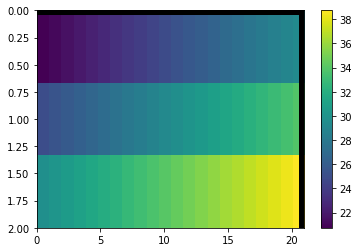

In [15]:
# Vehicule 1
i = 0 
M_distance = M_distance_time(X_coord,Y_coord,T_timestamp,X_mobile[i],Y_mobile[i],T_mobile[i])
alignment = dtw(M_distance)
ax = plt.imshow(M_distance,aspect='auto',interpolation='none', extent=[0,max(alignment.index2),max(alignment.index1),0])
plt.colorbar()
plt.plot([alignment.index2[k] for k in range(0,len(alignment.index2))],[alignment.index1[k] for k in range(0,len(alignment.index1))],'black',linewidth=10)

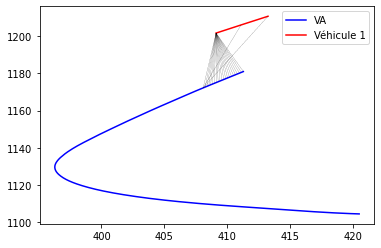

In [16]:
Chemin = [[alignment.index1[k],alignment.index2[k]] for k in range(0,len(alignment.index1))]

plt.plot(X_coord,Y_coord,'b',label='VA')
plt.plot([X_mobile[i][k] for k in range(0,len(X_mobile[i]))],[Y_mobile[i][k] for k in range(0,len(Y_mobile[i]))],'r',label = 'Véhicule '+str(i+1))
for k in range(0,len(Chemin)):
    trait_x_coord =[X_mobile[i][Chemin[k][0]],X_coord[Chemin[k][1]]]
    trait_y_coord =[Y_mobile[i][Chemin[k][0]],Y_coord[Chemin[k][1]]]
    plt.plot(trait_x_coord,trait_y_coord,'black',linestyle='--',linewidth=0.2)
plt.legend()

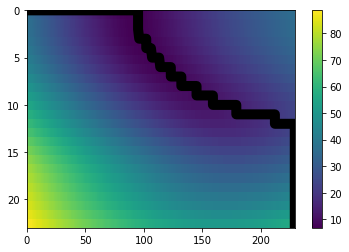

In [17]:
# Vehicule 2
i = 1
M_distance = M_distance_time(X_coord,Y_coord,T_timestamp,X_mobile[i],Y_mobile[i],T_mobile[i])
alignment = dtw(M_distance)
ax = plt.imshow(M_distance,aspect='auto',interpolation='none', extent=[0,max(alignment.index2),max(alignment.index1),0])
plt.colorbar()
plt.plot([alignment.index2[k] for k in range(0,len(alignment.index2))],[alignment.index1[k] for k in range(0,len(alignment.index1))],'black',linewidth=10)

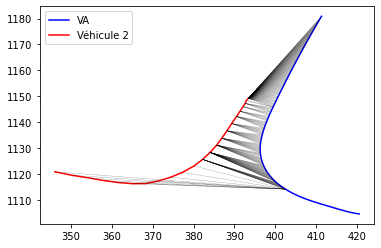

In [18]:
Chemin = [[alignment.index1[k],alignment.index2[k]] for k in range(0,len(alignment.index1))]

plt.plot(X_coord,Y_coord,'b',label='VA')
plt.plot([X_mobile[i][k] for k in range(0,len(X_mobile[i]))],[Y_mobile[i][k] for k in range(0,len(Y_mobile[i]))],'r',label = 'Véhicule '+str(i+1))
for k in range(0,len(Chemin)):
    trait_x_coord =[X_mobile[i][Chemin[k][0]],X_coord[Chemin[k][1]]]
    trait_y_coord =[Y_mobile[i][Chemin[k][0]],Y_coord[Chemin[k][1]]]
    plt.plot(trait_x_coord,trait_y_coord,'black',linestyle='--',linewidth=0.2)
plt.legend()

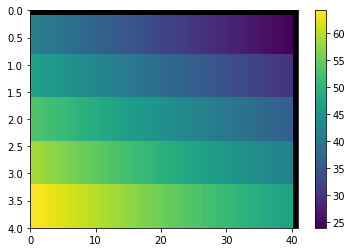

In [19]:
# Vehicule 3
i = 2
M_distance = M_distance_time(X_coord,Y_coord,T_timestamp,X_mobile[i],Y_mobile[i],T_mobile[i])
alignment = dtw(M_distance)
ax = plt.imshow(M_distance,aspect='auto',interpolation='none', extent=[0,max(alignment.index2),max(alignment.index1),0])
plt.colorbar()
plt.plot([alignment.index2[k] for k in range(0,len(alignment.index2))],[alignment.index1[k] for k in range(0,len(alignment.index1))],'black',linewidth=10)

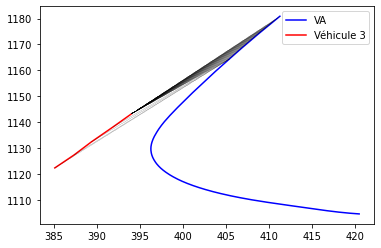

In [20]:
Chemin = [[alignment.index1[k],alignment.index2[k]] for k in range(0,len(alignment.index1))]

plt.plot(X_coord,Y_coord,'b',label='VA')
plt.plot([X_mobile[i][k] for k in range(0,len(X_mobile[i]))],[Y_mobile[i][k] for k in range(0,len(Y_mobile[i]))],'r',label = 'Véhicule '+str(i+1))
for k in range(0,len(Chemin)):
    trait_x_coord =[X_mobile[i][Chemin[k][0]],X_coord[Chemin[k][1]]]
    trait_y_coord =[Y_mobile[i][Chemin[k][0]],Y_coord[Chemin[k][1]]]
    plt.plot(trait_x_coord,trait_y_coord,'black',linestyle='--',linewidth=0.2)
plt.legend()

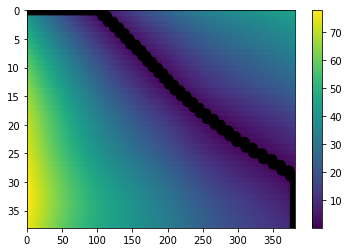

In [21]:
# Vehicule 4
i = 3
M_distance = M_distance_time(X_coord,Y_coord,T_timestamp,X_mobile[i],Y_mobile[i],T_mobile[i])
alignment = dtw(M_distance)
ax = plt.imshow(M_distance,aspect='auto',interpolation='none', extent=[0,max(alignment.index2),max(alignment.index1),0])
plt.colorbar()
plt.plot([alignment.index2[k] for k in range(0,len(alignment.index2))],[alignment.index1[k] for k in range(0,len(alignment.index1))],'black',linewidth=10)

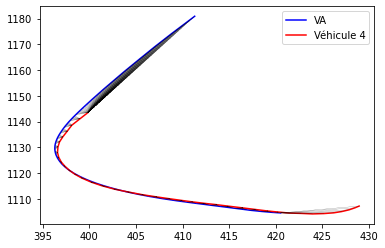

In [22]:
Chemin = [[alignment.index1[k],alignment.index2[k]] for k in range(0,len(alignment.index1))]

plt.plot(X_coord,Y_coord,'b',label='VA')
plt.plot([X_mobile[i][k] for k in range(0,len(X_mobile[i]))],[Y_mobile[i][k] for k in range(0,len(Y_mobile[i]))],'r',label = 'Véhicule '+str(i+1))
for k in range(0,len(Chemin)):
    trait_x_coord =[X_mobile[i][Chemin[k][0]],X_coord[Chemin[k][1]]]
    trait_y_coord =[Y_mobile[i][Chemin[k][0]],Y_coord[Chemin[k][1]]]
    plt.plot(trait_x_coord,trait_y_coord,'black',linestyle='--',linewidth=0.2)
plt.legend()

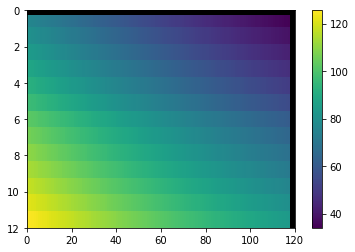

In [23]:
# Vehicule 5
i = 4
M_distance = M_distance_time(X_coord,Y_coord,T_timestamp,X_mobile[i],Y_mobile[i],T_mobile[i])
alignment = dtw(M_distance)
ax = plt.imshow(M_distance,aspect='auto',interpolation='none', extent=[0,max(alignment.index2),max(alignment.index1),0])
plt.colorbar()
plt.plot([alignment.index2[k] for k in range(0,len(alignment.index2))],[alignment.index1[k] for k in range(0,len(alignment.index1))],'black',linewidth=10)

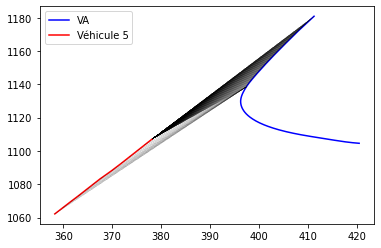

In [24]:
Chemin = [[alignment.index1[k],alignment.index2[k]] for k in range(0,len(alignment.index1))]

plt.plot(X_coord,Y_coord,'b',label='VA')
plt.plot([X_mobile[i][k] for k in range(0,len(X_mobile[i]))],[Y_mobile[i][k] for k in range(0,len(Y_mobile[i]))],'r',label = 'Véhicule '+str(i+1))
for k in range(0,len(Chemin)):
    trait_x_coord =[X_mobile[i][Chemin[k][0]],X_coord[Chemin[k][1]]]
    trait_y_coord =[Y_mobile[i][Chemin[k][0]],Y_coord[Chemin[k][1]]]
    plt.plot(trait_x_coord,trait_y_coord,'black',linestyle='--',linewidth=0.2)
plt.legend()

#### Travail sur les bus

In [25]:
# On travail sur les bus
catego_name = 'vehicle.bus.rigid'
catego_token = nusc.field2token('category','name',catego_name)
category = nusc.get('category',catego_token[0])
category

{'token': 'fedb11688db84088883945752e480c2c',
 'name': 'vehicle.bus.rigid',
 'description': 'Rigid bus subcategory.'}

In [26]:
# Ensemble des instances appartenant à la fois à la scène et à la catégorie
L_instance_category = nusc.field2token('instance','category_token',catego_token[0]) # instance dans la catégorie
L_instance_category = [x for x in L_instance_category if x in L_instance_token]# et dans la scène 

L=[]
for k in L_instance_category : 
    instance_category = nusc.get('instance',k)
    nbr_annotations = instance_category['nbr_annotations']
    if nbr_annotations == 1:
        L.append([instance_category['first_annotation_token']])
    else : 
        H = []
        first_token = instance_category['first_annotation_token']
        last_token = instance_category['last_annotation_token']
        current_token = first_token 
        
        i = 0 
        while i!= nbr_annotations :
            current_ann = nusc.get('sample_annotation', current_token)
            H.append(current_ann['token'])
            current_token = current_ann['next'] #On passe au suivant
            i+=1
        L.append(H)
# Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
# les token des sample_annotation pour un élément de cette catégorie. 

# Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
# on va pouvoir récupérer leurs positions 

X = []
Y = []
Z = []
T_time = []
for k in L :
    x = []
    y = []
    z = []
    t = []
    for j in k :
        sample_annotation = nusc.get('sample_annotation',j)
        x.append(sample_annotation['translation'][0])
        y.append(sample_annotation['translation'][1])
        z.append(sample_annotation['translation'][2])
        t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
    X.append(x)
    Y.append(y)
    Z.append(z)
    T_time.append(t)

Immo, Mobile = immobile(X,Y)

# On conserve uniquement les objets mobiles 
X_mobile=[X[i] for i in Mobile]
Y_mobile=[Y[i] for i in Mobile]
Z_mobile=[Z[i] for i in Mobile]
T_mobile = [T_time[i] for i in Mobile]
len(X_mobile)

1

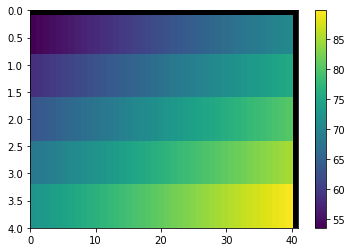

In [27]:
# Bus 1
i = 0
M_distance = M_distance_time(X_coord,Y_coord,T_timestamp,X_mobile[i],Y_mobile[i],T_mobile[i])
alignment = dtw(M_distance)
ax = plt.imshow(M_distance,aspect='auto',interpolation='none', extent=[0,max(alignment.index2),max(alignment.index1),0])
plt.colorbar()
plt.plot([alignment.index2[k] for k in range(0,len(alignment.index2))],[alignment.index1[k] for k in range(0,len(alignment.index1))],'black',linewidth=10)

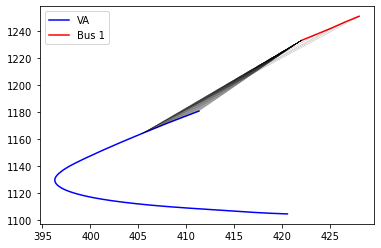

In [28]:
Chemin = [[alignment.index1[k],alignment.index2[k]] for k in range(0,len(alignment.index1))]

plt.plot(X_coord,Y_coord,'b',label='VA')
plt.plot([X_mobile[i][k] for k in range(0,len(X_mobile[i]))],[Y_mobile[i][k] for k in range(0,len(Y_mobile[i]))],'r',label = 'Bus '+str(i+1))
for k in range(0,len(Chemin)):
    trait_x_coord =[X_mobile[i][Chemin[k][0]],X_coord[Chemin[k][1]]]
    trait_y_coord =[Y_mobile[i][Chemin[k][0]],Y_coord[Chemin[k][1]]]
    plt.plot(trait_x_coord,trait_y_coord,'black',linestyle='--',linewidth=0.2)
plt.legend()

#### Travail sur les camions

In [29]:
# On travail sur les camions
catego_name = 'vehicle.truck'
catego_token = nusc.field2token('category','name',catego_name)
category = nusc.get('category',catego_token[0])
category

{'token': '6021b5187b924d64be64a702e5570edf',
 'name': 'vehicle.truck',
 'description': 'Vehicles primarily designed to haul cargo including pick-ups, lorrys, trucks and semi-tractors. Trailers hauled after a semi-tractor should be labeled as vehicle.trailer'}

In [30]:
# Ensemble des instances appartenant à la fois à la scène et à la catégorie
L_instance_category = nusc.field2token('instance','category_token',catego_token[0]) # instance dans la catégorie
L_instance_category = [x for x in L_instance_category if x in L_instance_token]# et dans la scène 

L=[]
for k in L_instance_category : 
    instance_category = nusc.get('instance',k)
    nbr_annotations = instance_category['nbr_annotations']
    if nbr_annotations == 1:
        L.append([instance_category['first_annotation_token']])
    else : 
        H = []
        first_token = instance_category['first_annotation_token']
        last_token = instance_category['last_annotation_token']
        current_token = first_token 
        
        i = 0 
        while i!= nbr_annotations :
            current_ann = nusc.get('sample_annotation', current_token)
            H.append(current_ann['token'])
            current_token = current_ann['next'] #On passe au suivant
            i+=1
        L.append(H)
# Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
# les token des sample_annotation pour un élément de cette catégorie. 

# Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
# on va pouvoir récupérer leurs positions 

X = []
Y = []
Z = []
T_time = []
for k in L :
    x = []
    y = []
    z = []
    t = []
    for j in k :
        sample_annotation = nusc.get('sample_annotation',j)
        x.append(sample_annotation['translation'][0])
        y.append(sample_annotation['translation'][1])
        z.append(sample_annotation['translation'][2])
        t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
    X.append(x)
    Y.append(y)
    Z.append(z)
    T_time.append(t)

Immo, Mobile = immobile(X,Y)

# On conserve uniquement les objets mobiles 
X_mobile=[X[i] for i in Mobile]
Y_mobile=[Y[i] for i in Mobile]
Z_mobile=[Z[i] for i in Mobile]
T_mobile = [T_time[i] for i in Mobile]
len(X_mobile)

1

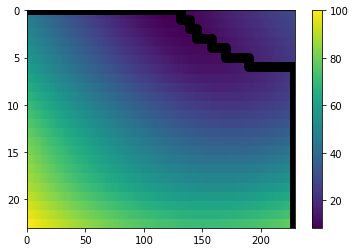

In [31]:
# Camion 1
i = 0
M_distance = M_distance_time(X_coord,Y_coord,T_timestamp,X_mobile[i],Y_mobile[i],T_mobile[i])
alignment = dtw(M_distance)
ax = plt.imshow(M_distance,aspect='auto',interpolation='none', extent=[0,max(alignment.index2),max(alignment.index1),0])
plt.colorbar()
plt.plot([alignment.index2[k] for k in range(0,len(alignment.index2))],[alignment.index1[k] for k in range(0,len(alignment.index1))],'black',linewidth=10)

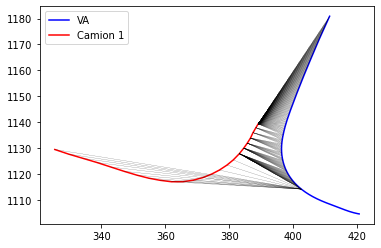

In [32]:
Chemin = [[alignment.index1[k],alignment.index2[k]] for k in range(0,len(alignment.index1))]

plt.plot(X_coord,Y_coord,'b',label='VA')
plt.plot([X_mobile[i][k] for k in range(0,len(X_mobile[i]))],[Y_mobile[i][k] for k in range(0,len(Y_mobile[i]))],'r',label = 'Camion '+str(i+1))
for k in range(0,len(Chemin)):
    trait_x_coord =[X_mobile[i][Chemin[k][0]],X_coord[Chemin[k][1]]]
    trait_y_coord =[Y_mobile[i][Chemin[k][0]],Y_coord[Chemin[k][1]]]
    plt.plot(trait_x_coord,trait_y_coord,'black',linestyle='--',linewidth=0.2)
plt.legend()

### Création des dataframes contenant les indicateurs 

In [162]:
## En utilisant le package 

#imports nécessaires
import matplotlib.pyplot as plt
from math import sqrt
import datetime 
from datetime import timedelta
from dtw import *
import pandas as pd
from statistics import mean

def indicateur_similarite(scene_name):
    
    # On crée une dataframe vide 
    df = pd.DataFrame()
    # Ligne de la dataframe 
    L_ligne = ['scene','Véhicule 1','Véhicule 2','Vitesse moyenne veh 1','Vitesse moyenne veh 2',\
               "Durée d'interaction",'DTW normalisée','Distance instantannée moyenne',\
               'Distance instantannée minimale','Distance instantannée maximale','TimeLag moyen horizontal',\
               'TimeLag moyen vertical',"Indicateur d'orthogonalité moyen","Indicateur d'orthogonalité min",\
               "Indicateur d'orthogonalité max",'Indicateur de colinéarité moyen',\
               'Indicateur de colinéarité min','Indicateur de colinéarité max',\
               'Distance minimale dans matrice distance','Distance maximale dans matrice distance',\
               'Distance moyenne dans matrice distance']
    # Les lignes en plus : 'Time log moyen'
    # On met ça en index 
    df['index']= L_ligne
    df.set_index('index',inplace=True)
    df.index.name = None
    
    # Dataframe des fenêtre glissantes 
    df_glissante = dtw_glissante(scene_name) 
    
    scene_token = nusc.field2token('scene','name',scene_name)[0]
    sample_token = nusc.field2token('sample','scene_token',scene_token)# Ensemble des token des échantillons de la scene 
    
    # Pour tracer la trajectoire du véhicule ego
    Liste_ego_poses = get_poses(scene_token) 
    X_coord =[]
    Y_coord =[]
    Z_coord =[]
    T_timestamp = [] # liste des timestamps
    for k in range(0,len(Liste_ego_poses)):
        X_coord.append(Liste_ego_poses[k]['translation'][0])
        Y_coord.append(Liste_ego_poses[k]['translation'][1])
        Z_coord.append(Liste_ego_poses[k]['translation'][2])
        T_timestamp.append(Liste_ego_poses[k]['timestamp'])
        
    # Ensemble des sample_annotation de la scène :
    sample_annotation_token = []
    for k in sample_token : 
        L = nusc.field2token('sample_annotation','sample_token',k)
        sample_annotation_token = sample_annotation_token + L
    
    # On créé la liste des token des instances présents dans les sample_annotation
    L_instance_token = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_instance_token.append(exemple['instance_token'])
    # Puisque pour un même objet, on peut avoir plusieurs annotations, on supprime les doublons de L
    L_instance_token = list(set(L_instance_token))
    
    # Liste des catégories d'objet dans la scène 
    L_category_name = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_category_name.append(exemple['category_name'])
    L_category_name = list(set(L_category_name)) #on supprime les doublons 
   
    L_vehicule = ['vehicle.bicycle','vehicle.bus.bendy','vehicle.bus.rigid','vehicle.car','vehicle.construction','vehicle.emergency.ambulance','vehicle.emergency.police','vehicle.motorcycle','vehicle.trailer','vehicle.truck']
    
    L_category_name = [k for k in L_category_name if k in L_vehicule]
    
    # Boucle sur chaque catégorie trouvée
    for j in range(0,len(L_category_name)):   
        catego_name = L_category_name[j]
        catego_token = nusc.field2token('category','name',catego_name)
        category = nusc.get('category',catego_token[0])

        # Ensemble des instances appartenant à la fois à la scène et à la catégorie
        L_instance_category = nusc.field2token('instance','category_token',catego_token[0]) # instance dans la catégorie
        L_instance_category = [x for x in L_instance_category if x in L_instance_token]# et dans la scène 
        L_instance_category
        
        # Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
        # les token des sample_annotation pour un élément de cette catégorie. 

        L=[]
        for k in L_instance_category : 
            instance_category = nusc.get('instance',k)
            nbr_annotations = instance_category['nbr_annotations']
            if nbr_annotations == 1:
                L.append([instance_category['first_annotation_token']])
            else : 
                H = []
                first_token = instance_category['first_annotation_token']
                last_token = instance_category['last_annotation_token']
                current_token = first_token 
        
                s = 0 
                while s!= nbr_annotations :
                    current_ann = nusc.get('sample_annotation', current_token)
                    H.append(current_ann['token'])
                    current_token = current_ann['next'] #On passe au suivant
                    s+=1
                L.append(H)
        
        # Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
        # on va pouvoir récupérer leurs positions et tracer leurs trajectoires

        X = []
        Y = []
        Z = []
        T_time = []
        for k in L :
            x = []
            y = []
            z = []
            t=[]
            for j in k :
                sample_annotation = nusc.get('sample_annotation',j)
                x.append(sample_annotation['translation'][0])
                y.append(sample_annotation['translation'][1])
                z.append(sample_annotation['translation'][2])
                t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
            X.append(x)
            Y.append(y)
            Z.append(z)
            T_time.append(t)
    
        # On crée les listes des objets immobiles et mobiles de la catégorie
        Immo, Mobile = immobile(X,Y)
        
        # On conserve uniquement les objets mobiles 
        X_mobile=[X[i] for i in Mobile]
        Y_mobile=[Y[i] for i in Mobile]
        Z_mobile=[Z[i] for i in Mobile]
        T_mobile = [T_time[i] for i in Mobile]
        
        for i in range(0,len(X_mobile)):
            L_objet = [] 
            # nom du véhicule 
            nom = catego_name +' '+str(i+1)
            
            ## Scene 
            L_objet.append(scene_name)
            
            ## Véhicule 1
            L_objet.append('vehicle.ego')
            
            ## Véhicule 2
            L_objet.append(nom)
            
            ## Vitesses moyennes 
            v_moy_ego, v_moy_veh = vitesse_moyenne(X_coord,Y_coord,T_timestamp,X_mobile[i],Y_mobile[i],T_mobile[i])
            L_objet.append(v_moy_ego)
            L_objet.append(v_moy_veh)
            
            ## Durée d'interaction 
            debut = max(T_mobile[i][0],T_timestamp[0])
            fin = min(T_mobile[i][-1],T_timestamp[-1])
            t_total = (datetime.datetime.fromtimestamp(fin/1e6)-datetime.datetime.fromtimestamp(debut/ 1e6)).total_seconds()
            L_objet.append(t_total)
            
            ## DTW normalisée
            #M_distance = Matrice_distance(X_coord,Y_coord,X_mobile[i],Y_mobile[i])
            M_distance = M_distance_time(X_coord,Y_coord,T_timestamp,X_mobile[i],Y_mobile[i],T_mobile[i])
            alignment = dtw(M_distance)
            distance = alignment.normalizedDistance
            L_objet.append(distance)
            
            Chemin = [[alignment.index1[k],alignment.index2[k]] for k in range(0,len(alignment.index1))]
            
            ## Distance instannée moyenne 
            L_objet.append(df_glissante[nom].mean())
            
            ## Distance instannée minimale
            L_objet.append(df_glissante[nom].min())
            
            ## Distance instannée maximale
            L_objet.append(df_glissante[nom].max())
            
            ## Time log moyen horizontal
            recurrence_0 = list(alignment.index1).count(0)
            indice_max_ego = alignment.index2[recurrence_0-1]
            t_horizontal = (datetime.datetime.fromtimestamp(T_timestamp[indice_max_ego]/1e6)-datetime.datetime.fromtimestamp(T_timestamp[0]/ 1e6)).total_seconds()
            L_objet.append(t_horizontal)
            
            ## Time log moyen vertical
            N = max(alignment.index2)
            recurrence_N = list(alignment.index2).count(N)
            indice_min_veh = alignment.index1[len(alignment.index1)-recurrence_N]
            t_vertical = (datetime.datetime.fromtimestamp(T_mobile[i][max(alignment.index1)]/1e6)-datetime.datetime.fromtimestamp(T_mobile[i][indice_min_veh]/ 1e6)).total_seconds()
            L_objet.append(t_vertical)
            
            ## Indicateur d'orthogonalité moyen : sin 
            M_pv = Matrice_produit_vectoriel(X_coord,Y_coord,T_timestamp,X_mobile[i],Y_mobile[i],T_mobile[i])
            L_pv = [M_pv[i,j] for(i,j) in Chemin[:len(Chemin)] if i<max(alignment.index1) and j<max(alignment.index2)]
            L_objet.append(mean(L_pv))
            
            ## Indicateur d'orthogonalité min 
            L_objet.append(min(L_pv))
            
            ## Indicateur d'orthogonalité max
            L_objet.append(max(L_pv))
            
            ## Indicateur de colinéarité moyen : cos
            M_ps = Matrice_produit_scalaire(X_coord,Y_coord,T_timestamp,X_mobile[i],Y_mobile[i],T_mobile[i])
            L_ps = [M_ps[i,j] for(i,j) in Chemin[:len(Chemin)] if i<max(alignment.index1) and j<max(alignment.index2)]
            L_objet.append(mean(L_ps))
            
            ## Indicateur de colinéarité min
            L_objet.append(min(L_ps))
            
            ## Indicateur de colinéarité max
            L_objet.append(max(L_ps))

            ## Distance min dans la matrice 
            L_objet.append(M_distance.min())
            
            ## Distance max dans la matrice 
            L_objet.append(M_distance.max()) 
            
            ## Distance moyenne dans la matrice 
            L_objet.append(M_distance.mean()) 
            
            nom = catego_name +' '+str(i+1)+'/ego dans '+scene_name
            df[nom]=L_objet
    return df.transpose()
    

In [163]:
scene_name = 'scene-0061'
df_61 = indicateur_similarite(scene_name)
df_61

,scene,Véhicule 1,Véhicule 2,Vitesse moyenne veh 1,Vitesse moyenne veh 2,Durée d'interaction,DTW normalisée,Distance instantannée moyenne,Distance instantannée minimale,Distance instantannée maximale,...,TimeLag moyen vertical,Indicateur d'orthogonalité moyen,Indicateur d'orthogonalité min,Indicateur d'orthogonalité max,Indicateur de colinéarité moyen,Indicateur de colinéarité min,Indicateur de colinéarité max,Distance minimale dans matrice distance,Distance maximale dans matrice distance,Distance moyenne dans matrice distance
vehicle.car 1/ego dans scene-0061,scene-0061,vehicle.ego,vehicle.car 1,8.862925,9.459852,1.050097,24.953401,32.364935,24.142933,40.586937,...,1.050097,0.076894,0.063754,0.084432,-0.997027,-0.997966,-0.996429,20.739661,38.735602,29.578912
vehicle.car 2/ego dans scene-0061,scene-0061,vehicle.ego,vehicle.car 2,6.155384,5.78235,11.499383,15.844434,26.217761,15.506647,54.255603,...,5.500872,0.393398,0.092346,0.996106,0.831509,0.088161,0.995727,6.787707,88.709867,33.192634
vehicle.car 3/ego dans scene-0061,scene-0061,vehicle.ego,vehicle.car 3,8.564618,11.088804,2.049846,32.294648,38.263151,35.404644,41.083774,...,2.049846,0.059173,0.036886,0.078373,0.99819,0.996924,0.999319,23.975892,64.147662,43.973192
vehicle.car 4/ego dans scene-0061,scene-0061,vehicle.ego,vehicle.car 4,4.77538,3.222342,19.149566,5.050621,14.823187,6.696696,32.984968,...,4.600054,0.035928,0.00008,0.140614,0.998951,0.990065,1.0,0.037589,77.803221,25.983685
vehicle.car 5/ego dans scene-0061,scene-0061,vehicle.ego,vehicle.car 5,7.172089,8.206919,5.998504,53.675439,72.63744,68.295421,78.957768,...,5.998504,0.108906,0.055613,0.226646,0.993171,0.973977,0.998452,34.032382,125.55427,78.287636
vehicle.bus.rigid 1/ego dans scene-0061,scene-0061,vehicle.ego,vehicle.bus.rigid 1,8.564618,9.255912,2.049846,62.784244,72.53295,55.787752,88.573954,...,2.049846,0.011213,0.000274,0.03069,-0.999907,-1.0,-0.999529,53.479254,89.795179,71.922482
vehicle.truck 1/ego dans scene-0061,scene-0061,vehicle.ego,vehicle.truck 1,6.155384,6.667293,11.499383,21.272493,41.538593,30.573171,74.851973,...,8.499009,0.384397,0.082333,0.993241,0.827521,0.116069,0.996605,8.451707,100.054996,43.899822


In [164]:
# scene-0103
scene_name = 'scene-0103'
df_103 = indicateur_similarite(scene_name)
#df_103

/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars
/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars


In [165]:
# scene-0655
scene_name = 'scene-0655'
df_655 = indicateur_similarite(scene_name)
#df_655

In [166]:
# scene-0553
scene_name = 'scene-0553'
df_553 = indicateur_similarite(scene_name)
#df_553

/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars
/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars


In [167]:
# scene-0757
scene_name = 'scene-0757'
df_757 = indicateur_similarite(scene_name)
#df_757

/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars
/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars


In [168]:
# scene-0796
scene_name = 'scene-0796'
df_796 = indicateur_similarite(scene_name)
#df_796

/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars
/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars


In [169]:
# scene-0916
scene_name = 'scene-0916'
df_916 = indicateur_similarite(scene_name)
#df_916

/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars
/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars


In [170]:
# scene-1077
scene_name = 'scene-1077'
df_1077 = indicateur_similarite(scene_name)
#df_1077

/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars
/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars


In [171]:
# scene-1094
scene_name = 'scene-1094'
df_1094 = indicateur_similarite(scene_name)
#df_1094

In [172]:
# scene-1100
scene_name = 'scene-1100'
df_1100 = indicateur_similarite(scene_name)
#df_1100

/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars
/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars


In [173]:
# On rassemble toutes ces dataframe en une seule 
DF = pd.concat([df_61, df_103, df_655, df_553,df_757, df_796, df_916, df_1077, df_1094, df_1100])
DF

,scene,Véhicule 1,Véhicule 2,Vitesse moyenne veh 1,Vitesse moyenne veh 2,Durée d'interaction,DTW normalisée,Distance instantannée moyenne,Distance instantannée minimale,Distance instantannée maximale,...,TimeLag moyen vertical,Indicateur d'orthogonalité moyen,Indicateur d'orthogonalité min,Indicateur d'orthogonalité max,Indicateur de colinéarité moyen,Indicateur de colinéarité min,Indicateur de colinéarité max,Distance minimale dans matrice distance,Distance maximale dans matrice distance,Distance moyenne dans matrice distance
vehicle.car 1/ego dans scene-0061,scene-0061,vehicle.ego,vehicle.car 1,8.862925,9.459852,1.050097,24.953401,32.364935,24.142933,40.586937,...,1.050097,0.076894,0.063754,0.084432,-0.997027,-0.997966,-0.996429,20.739661,38.735602,29.578912
vehicle.car 2/ego dans scene-0061,scene-0061,vehicle.ego,vehicle.car 2,6.155384,5.78235,11.499383,15.844434,26.217761,15.506647,54.255603,...,5.500872,0.393398,0.092346,0.996106,0.831509,0.088161,0.995727,6.787707,88.709867,33.192634
vehicle.car 3/ego dans scene-0061,scene-0061,vehicle.ego,vehicle.car 3,8.564618,11.088804,2.049846,32.294648,38.263151,35.404644,41.083774,...,2.049846,0.059173,0.036886,0.078373,0.99819,0.996924,0.999319,23.975892,64.147662,43.973192
vehicle.car 4/ego dans scene-0061,scene-0061,vehicle.ego,vehicle.car 4,4.77538,3.222342,19.149566,5.050621,14.823187,6.696696,32.984968,...,4.600054,0.035928,0.00008,0.140614,0.998951,0.990065,1.0,0.037589,77.803221,25.983685
vehicle.car 5/ego dans scene-0061,scene-0061,vehicle.ego,vehicle.car 5,7.172089,8.206919,5.998504,53.675439,72.63744,68.295421,78.957768,...,5.998504,0.108906,0.055613,0.226646,0.993171,0.973977,0.998452,34.032382,125.55427,78.287636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vehicle.car 8/ego dans scene-1100,scene-1100,vehicle.ego,vehicle.car 8,0.000252,10.844017,2.999271,39.525627,48.808348,34.832441,63.320613,...,0.0,0.797778,0.786105,0.802074,-0.602888,-0.618094,-0.597225,38.315502,70.735547,55.543515
vehicle.car 9/ego dans scene-1100,scene-1100,vehicle.ego,vehicle.car 9,0.068709,3.858691,16.499781,18.153815,44.881757,14.943915,62.528917,...,16.499781,0.728921,0.000396,0.999999,0.375019,-0.261426,1.0,14.668761,66.569221,46.934998
vehicle.car 10/ego dans scene-1100,scene-1100,vehicle.ego,vehicle.car 10,0.000904,10.875512,1.500177,36.300017,40.119013,35.010219,45.227807,...,1.500177,0.892753,0.457852,0.999624,0.099266,-0.537538,0.889029,36.422604,52.501291,44.453959
vehicle.car 11/ego dans scene-1100,scene-1100,vehicle.ego,vehicle.car 11,0.008808,10.122451,7.498687,7.559059,27.860522,4.713065,60.003432,...,0.499887,0.450298,0.00907,0.97395,0.393722,-0.894795,0.999959,4.931301,67.33188,32.636504


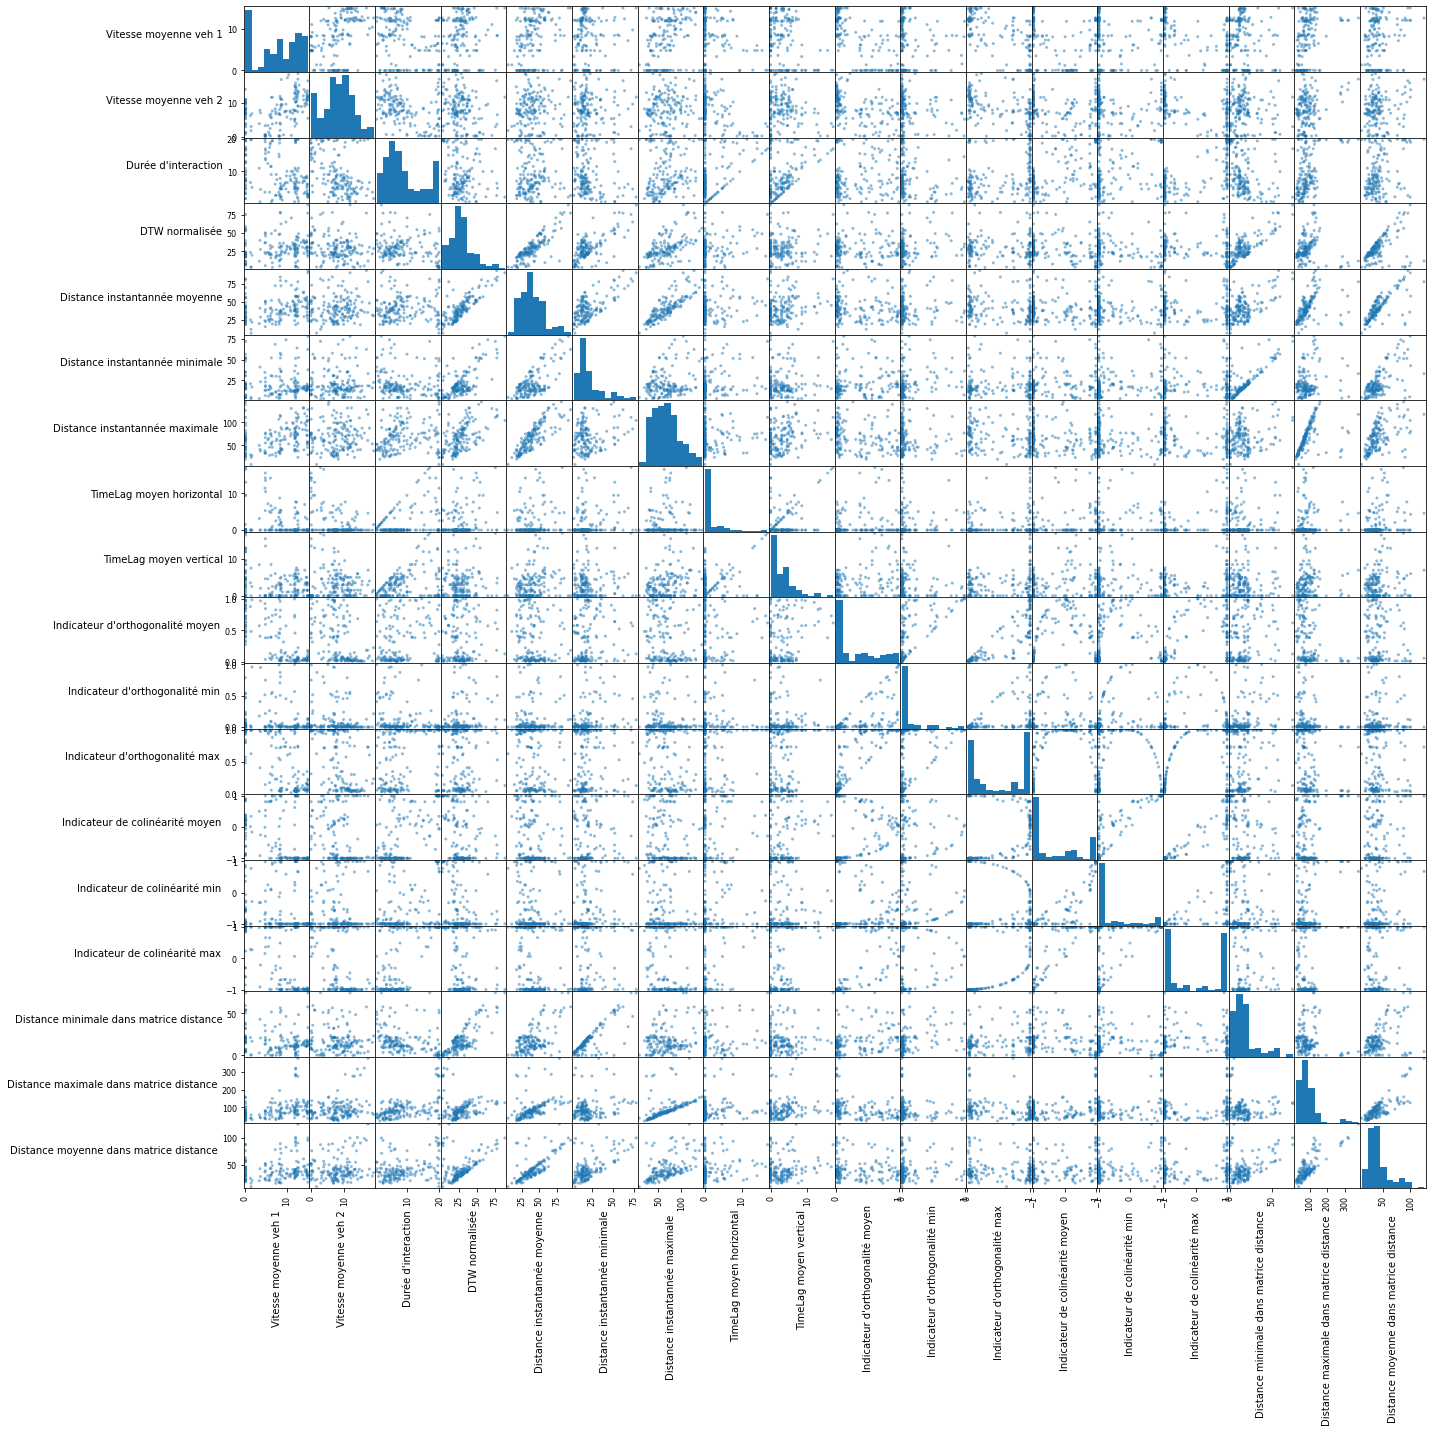

In [174]:
## On va tracer les courbes des colonnes les unes par rapport aux autres, 

# On converti le type des colonnes en float d'abbord
DF[list(DF.columns[3:])] = DF[list(DF.columns[3:])].apply(pd.to_numeric)
axes = pd.plotting.scatter_matrix(DF,figsize=(20,20))
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

plt.tight_layout()
plt.gcf().subplots_adjust(wspace=0, hspace=0)
plt.show()

#### On étend le calcul à une l'étude des interractions entre les véhicules 

In [ ]:
## Il faut reprendre la fonction fenêtre glissante 

In [207]:
#imports nécessaires
import matplotlib.pyplot as plt
from math import sqrt
import datetime 
from datetime import timedelta
from dtw import *
import pandas as pd
from statistics import mean

def indicateur_similarite_entre_veh(scene_name):
    
    # On crée une dataframe vide 
    df = pd.DataFrame()
    # Ligne de la dataframe 
    
    L_ligne = ['scene','Véhicule 1','Véhicule 2','Vitesse moyenne veh 1','Vitesse moyenne veh 2',\
               "Durée d'interaction",'DTW normalisée','Distance instantannée moyenne',\
               'Distance instantannée minimale','Distance instantannée maximale','TimeLag moyen horizontal',\
               'TimeLag moyen vertical',"Indicateur d'orthogonalité moyen","Indicateur d'orthogonalité min",\
               "Indicateur d'orthogonalité max",'Indicateur de colinéarité moyen',\
               'Indicateur de colinéarité min','Indicateur de colinéarité max',\
               'Distance minimale dans matrice distance','Distance maximale dans matrice distance',\
               'Distance moyenne dans matrice distance']
   
    # On met ça en index 
    df['index']= L_ligne
    df.set_index('index',inplace=True)
    df.index.name = None 

    scene_token = nusc.field2token('scene','name',scene_name)[0]
    sample_token = nusc.field2token('sample','scene_token',scene_token)# Ensemble des token des échantillons de la scene 
    
    # Pour tracer la trajectoire du véhicule ego
    Liste_ego_poses = get_poses(scene_token) 
    X_coord =[]
    Y_coord =[]
    Z_coord =[]
    T_timestamp = [] # liste des timestamps
    for k in range(0,len(Liste_ego_poses)):
        X_coord.append(Liste_ego_poses[k]['translation'][0])
        Y_coord.append(Liste_ego_poses[k]['translation'][1])
        Z_coord.append(Liste_ego_poses[k]['translation'][2])
        T_timestamp.append(Liste_ego_poses[k]['timestamp'])
        
    # Ensemble des sample_annotation de la scène :
    sample_annotation_token = []
    for k in sample_token : 
        L = nusc.field2token('sample_annotation','sample_token',k)
        sample_annotation_token = sample_annotation_token + L
    
    # On créé la liste des token des instances présents dans les sample_annotation
    L_instance_token = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_instance_token.append(exemple['instance_token'])
    # Puisque pour un même objet, on peut avoir plusieurs annotations, on supprime les doublons de L
    L_instance_token = list(set(L_instance_token))
    
    # Liste des catégories d'objet dans la scène 
    L_category_name = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_category_name.append(exemple['category_name'])
    L_category_name = list(set(L_category_name)) #on supprime les doublons 
   
    L_vehicule = ['vehicle.bicycle','vehicle.bus.bendy','vehicle.bus.rigid','vehicle.car','vehicle.construction','vehicle.emergency.ambulance','vehicle.emergency.police','vehicle.motorcycle','vehicle.trailer','vehicle.truck']
    
    L_category_name = [k for k in L_category_name if k in L_vehicule]
    
    # Boucle sur chaque catégorie trouvée
    for j in range(0,len(L_category_name)):   
        catego_name = L_category_name[j]
        catego_token = nusc.field2token('category','name',catego_name)
        category = nusc.get('category',catego_token[0])

        # Ensemble des instances appartenant à la fois à la scène et à la catégorie
        L_instance_category = nusc.field2token('instance','category_token',catego_token[0]) # instance dans la catégorie
        L_instance_category = [x for x in L_instance_category if x in L_instance_token]# et dans la scène 
        L_instance_category
        
        # Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
        # les token des sample_annotation pour un élément de cette catégorie. 

        L=[]
        for k in L_instance_category : 
            instance_category = nusc.get('instance',k)
            nbr_annotations = instance_category['nbr_annotations']
            if nbr_annotations == 1:
                L.append([instance_category['first_annotation_token']])
            else : 
                H = []
                first_token = instance_category['first_annotation_token']
                last_token = instance_category['last_annotation_token']
                current_token = first_token 
        
                s = 0 
                while s!= nbr_annotations :
                    current_ann = nusc.get('sample_annotation', current_token)
                    H.append(current_ann['token'])
                    current_token = current_ann['next'] #On passe au suivant
                    s+=1
                L.append(H)
        
        # Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
        # on va pouvoir récupérer leurs positions et tracer leurs trajectoires

        X = []
        Y = []
        Z = []
        T_time = []
        for k in L :
            x = []
            y = []
            z = []
            t=[]
            for f in k :
                sample_annotation = nusc.get('sample_annotation',f)
                x.append(sample_annotation['translation'][0])
                y.append(sample_annotation['translation'][1])
                z.append(sample_annotation['translation'][2])
                t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
            X.append(x)
            Y.append(y)
            Z.append(z)
            T_time.append(t)
    
        # On crée les listes des objets immobiles et mobiles de la catégorie
        Immo, Mobile = immobile(X,Y)
        
        # On conserve uniquement les objets mobiles 
        X_mobile=[X[i] for i in Mobile]
        Y_mobile=[Y[i] for i in Mobile]
        Z_mobile=[Z[i] for i in Mobile]
        T_mobile = [T_time[i] for i in Mobile]
        
        for i in range(0,len(X_mobile)):
            
            if len(X_mobile)>1:
                
                for k in range(i+1,len(X_mobile)):

                    L_objet = [] 
                    # nom du véhicule 
                    nom = catego_name +' '+str(i+1)+' /'+ catego_name+' '+str(k+1)+' '+ scene_name
                    
                    ## Scene_name
                    L_objet.append(scene_name)
                    
                    ## Véhicule 1 
                    L_objet.append(catego_name +' '+str(i+1))
                    
                    ## Véhicule 2 
                    L_objet.append(catego_name +' '+str(k+1))
                    
                    ## Vitesses moyennes 
                    v_moy_veh1, v_moy_veh2 = vitesse_moyenne(X_mobile[i],Y_mobile[i],T_mobile[i],X_mobile[k],Y_mobile[k],T_mobile[k])
                    L_objet.append(v_moy_veh1)
                    L_objet.append(v_moy_veh2)
                    
                    ## Durée d'interaction 
                    debut = max(T_mobile[i][0],T_mobile[k][0])
                    fin = min(T_mobile[i][-1],T_mobile[k][-1])
                    t_total = (datetime.datetime.fromtimestamp(fin/1e6)-datetime.datetime.fromtimestamp(debut/ 1e6)).total_seconds()
                    if t_total >0 :
                        L_objet.append(t_total)
                    else :
                        L_objet.append(np.nan)
                        

                    ## DTW normalisée
                    M_distance =M_distance_time(X_mobile[i],Y_mobile[i],T_mobile[i],X_mobile[k],Y_mobile[k],T_mobile[k])
                    
                    if len(M_distance)>0 :
                    
                        alignment = dtw(M_distance)
                        distance = alignment.normalizedDistance
                        L_objet.append(distance)

                        Chemin = [[alignment.index1[k],alignment.index2[k]] for k in range(0,len(alignment.index1))]

                        ### Fenêtre glissante 

                        L_df = []
                        # On fait une boucle sur les intervalles de temps 
                        for m in range(0,20):
                            current_intervalle = [m,m+1]
                            # On crée les listes des coordonnées qu'on va garder ie qui sont dans l'intervalle de temps ci-dessus
                            Lx_pt_veh1 = []
                            Ly_pt_veh1 = []
                            Lt_pt_veh1 = []
                            Lx_pt_veh2 = []
                            Ly_pt_veh2 = []
                            Lt_pt_veh2 = []

                            # On remplit avec les pts du véhicule dont le timestamp est dans l'intervalle 
                            for s in range(len(X_mobile[i])):
                                tveh1 = (datetime.datetime.fromtimestamp(T_mobile[i][s]/1e6)-datetime.datetime.fromtimestamp(T_timestamp[0]/ 1e6)).total_seconds()
                                if tveh1 <= current_intervalle[1] and tveh1 >= current_intervalle[0] :
                                    Lx_pt_veh1.append(X_mobile[i][s])
                                    Ly_pt_veh1.append(Y_mobile[i][s])
                                    Lt_pt_veh1.append(T_mobile[i][s])

                            # On remplit avec les pts du véhicule ego dont le timestamp est dans l'intervalle 
                            for s in range(len(X_mobile[k])):
                                tveh2 = (datetime.datetime.fromtimestamp(T_mobile[k][s]/1e6)-datetime.datetime.fromtimestamp(T_timestamp[0]/ 1e6)).total_seconds()
                                if tveh2 <= current_intervalle[1] and tveh2 >= current_intervalle[0]:
                                    Lx_pt_veh2.append(X_mobile[k][s])
                                    Ly_pt_veh2.append(Y_mobile[k][s])
                                    Lt_pt_veh2.append(T_mobile[k][s])

                            if len(Lx_pt_veh1)>0 and len(Lx_pt_veh2)>0:
                                #M_distance_glissante = M_distance_time(Lx_pt_veh1,Ly_pt_veh1,Lt_pt_veh1,Lx_pt_veh2,Ly_pt_veh2,Lt_pt_veh2)
                                M_distance_glissante = Matrice_distance(Lx_pt_veh2,Ly_pt_veh2,Lx_pt_veh1,Ly_pt_veh1)
                                alignment_glissante = dtw(M_distance_glissante)
                                distance_glissante = alignment_glissante.normalizedDistance
                                L_df.append(distance_glissante) 

                        ## Distance instannée moyenne 
                        L_objet.append(mean(L_df))

                        ## Distance instannée minimale
                        L_objet.append(min(L_df))

                        ## Distance instannée maximale
                        L_objet.append(max(L_df))

                        ## Time log moyen horizontal
                        recurrence_0 = list(alignment.index1).count(0)
                        indice_max_ego = alignment.index2[recurrence_0-1]
                        t_horizontal = (datetime.datetime.fromtimestamp(T_mobile[i][indice_max_ego]/1e6)-datetime.datetime.fromtimestamp(T_mobile[i][0]/ 1e6)).total_seconds()
                        L_objet.append(t_horizontal)

                        ## Time log moyen vertical
                        N = max(alignment.index2)
                        recurrence_N = list(alignment.index2).count(N)
                        indice_min_veh = alignment.index1[len(alignment.index1)-recurrence_N]
                        t_vertical = (datetime.datetime.fromtimestamp(T_mobile[k][max(alignment.index1)]/1e6)-datetime.datetime.fromtimestamp(T_mobile[k][indice_min_veh]/ 1e6)).total_seconds()
                        L_objet.append(t_vertical)

                        ## Indicateur d'orthogonalité : sin 
                        M_pv = Matrice_produit_vectoriel(X_mobile[i],Y_mobile[i],T_mobile[i],X_mobile[k],Y_mobile[k],T_mobile[k])
                        L_pv = [M_pv[i,j] for(i,j) in Chemin[:len(Chemin)] if i<max(alignment.index1) and j<max(alignment.index2)]
                        if len(L_pv)>0:
                            L_objet.append(mean(L_pv))
                            L_objet.append(min(L_pv))
                            L_objet.append(max(L_pv))
                        else :
                            L_objet.append(np.nan)
                            L_objet.append(np.nan)
                            L_objet.append(np.nan)

                        ## Indicateur de colinéarité : cos
                        M_ps = Matrice_produit_scalaire(X_mobile[i],Y_mobile[i],T_mobile[i],X_mobile[k],Y_mobile[k],T_mobile[k])
                        L_ps = [M_ps[i,j] for(i,j) in Chemin[:len(Chemin)] if i<max(alignment.index1) and j<max(alignment.index2)]
                        if len(L_ps)>0:
                            L_objet.append(mean(L_ps))
                            L_objet.append(min(L_ps))
                            L_objet.append(max(L_ps))
                        else : 
                            L_objet.append(np.nan)
                            L_objet.append(np.nan)
                            L_objet.append(np.nan)
        
        
                        ## Distance min dans la matrice 
                        L_objet.append(M_distance.min())

                        ## Distance max dans la matrice 
                        L_objet.append(M_distance.max()) 

                        ## Distance moyenne dans la matrice 
                        L_objet.append(M_distance.mean()) 
                    
                    else : 
                        L_objet = L_objet + [np.nan]*15
                        
                    df[nom]=L_objet
            
            # On s'occuper maintenant des relations inter-catégories 
            for h in range(j+1,len(L_category_name)):   
                catego_name2 = L_category_name[h]
                catego_token2 = nusc.field2token('category','name',catego_name2)
                category2 = nusc.get('category',catego_token2[0])

                # Ensemble des instances appartenant à la fois à la scène et à la catégorie
                L_instance_category2 = nusc.field2token('instance','category_token',catego_token2[0]) # instance dans la catégorie
                L_instance_category2 = [x for x in L_instance_category2 if x in L_instance_token]# et dans la scène 

                # Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
                # les token des sample_annotation pour un élément de cette catégorie. 

                L2=[]
                for k in L_instance_category2 : 
                    instance_category = nusc.get('instance',k)
                    nbr_annotations = instance_category['nbr_annotations']
                    if nbr_annotations == 1:
                        L.append([instance_category['first_annotation_token']])
                    else : 
                        H = []
                        first_token = instance_category['first_annotation_token']
                        last_token = instance_category['last_annotation_token']
                        current_token = first_token 

                        s = 0 
                        while s!= nbr_annotations :
                            current_ann = nusc.get('sample_annotation', current_token)
                            H.append(current_ann['token'])
                            current_token = current_ann['next'] #On passe au suivant
                            s+=1
                        L2.append(H)

                # Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
                # on va pouvoir récupérer leurs positions et tracer leurs trajectoires

                X2 = []
                Y2 = []
                Z2 = []
                T2_time = []
                for k in L2 :
                    x = []
                    y = []
                    z = []
                    t=[]
                    for f in k :
                        sample_annotation = nusc.get('sample_annotation',f)
                        x.append(sample_annotation['translation'][0])
                        y.append(sample_annotation['translation'][1])
                        z.append(sample_annotation['translation'][2])
                        t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
                    X2.append(x)
                    Y2.append(y)
                    Z2.append(z)
                    T2_time.append(t)

                # On crée les listes des objets immobiles et mobiles de la catégorie
                Immo2, Mobile2 = immobile(X2,Y2)

                # On conserve uniquement les objets mobiles 
                X2_mobile=[X2[i] for i in Mobile2]
                Y2_mobile=[Y2[i] for i in Mobile2]
                Z2_mobile=[Z2[i] for i in Mobile2]
                T2_mobile = [T2_time[i] for i in Mobile2]
                
                if len(X2_mobile)>0:
                    
                    for n in range(0,len(X2_mobile)):
                        L_objet = [] 
                        # nom du véhicule 
                        nom = catego_name +' '+str(i+1)+' /'+ catego_name2+' '+str(n+1)+' '+ scene_name

                        ## Scene_name
                        L_objet.append(scene_name)

                        ## Véhicule 1 
                        L_objet.append(catego_name +' '+str(i+1))

                        ## Véhicule 2 
                        L_objet.append(catego_name2 +' '+str(n+1))

                        ## Vitesses moyennes 
                        v_moy_veh1, v_moy_veh2 = vitesse_moyenne(X_mobile[i],Y_mobile[i],T_mobile[i],X2_mobile[n],Y2_mobile[n],T2_mobile[n])
                        L_objet.append(v_moy_veh1)
                        L_objet.append(v_moy_veh2)

                        ## Durée d'interaction 
                        debut = max(T_mobile[i][0],T2_mobile[n][0])
                        fin = min(T_mobile[i][-1],T2_mobile[n][-1])
                        t_total = (datetime.datetime.fromtimestamp(fin/1e6)-datetime.datetime.fromtimestamp(debut/ 1e6)).total_seconds()
                        if t_total >0 :
                            L_objet.append(t_total)
                        else :
                            L_objet.append(np.nan)


                        ## DTW normalisée
                        M_distance =M_distance_time(X_mobile[i],Y_mobile[i],T_mobile[i],X2_mobile[n],Y2_mobile[n],T2_mobile[n])

                        if len(M_distance)>0 :

                            alignment = dtw(M_distance)
                            distance = alignment.normalizedDistance
                            L_objet.append(distance)

                            Chemin = [[alignment.index1[k],alignment.index2[k]] for k in range(0,len(alignment.index1))]

                            ### Fenêtre glissante 

                            L_df = []
                            # On fait une boucle sur les intervalles de temps 
                            for m in range(0,20):
                                current_intervalle = [m,m+1]
                                # On crée les listes des coordonnées qu'on va garder ie qui sont dans l'intervalle de temps ci-dessus
                                Lx_pt_veh1 = []
                                Ly_pt_veh1 = []
                                Lt_pt_veh1 = []
                                Lx_pt_veh2 = []
                                Ly_pt_veh2 = []
                                Lt_pt_veh2 = []

                                # On remplit avec les pts du véhicule dont le timestamp est dans l'intervalle 
                                for s in range(len(X_mobile[i])):
                                    tveh1 = (datetime.datetime.fromtimestamp(T_mobile[i][s]/1e6)-datetime.datetime.fromtimestamp(T_timestamp[0]/ 1e6)).total_seconds()
                                    if tveh1 <= current_intervalle[1] and tveh1 >= current_intervalle[0] :
                                        Lx_pt_veh1.append(X_mobile[i][s])
                                        Ly_pt_veh1.append(Y_mobile[i][s])
                                        Lt_pt_veh1.append(T_mobile[i][s])

                                # On remplit avec les pts du véhicule ego dont le timestamp est dans l'intervalle 
                                for s in range(len(X2_mobile[n])):
                                    tveh2 = (datetime.datetime.fromtimestamp(T2_mobile[n][s]/1e6)-datetime.datetime.fromtimestamp(T_timestamp[0]/ 1e6)).total_seconds()
                                    if tveh2 <= current_intervalle[1] and tveh2 >= current_intervalle[0]:
                                        Lx_pt_veh2.append(X2_mobile[n][s])
                                        Ly_pt_veh2.append(Y2_mobile[n][s])
                                        Lt_pt_veh2.append(T2_mobile[n][s])

                                if len(Lx_pt_veh1)>0 and len(Lx_pt_veh2)>0:
                                    #M_distance_glissante = M_distance_time(Lx_pt_veh1,Ly_pt_veh1,Lt_pt_veh1,Lx_pt_veh2,Ly_pt_veh2,Lt_pt_veh2)
                                    M_distance_glissante = Matrice_distance(Lx_pt_veh2,Ly_pt_veh2,Lx_pt_veh1,Ly_pt_veh1)
                                    alignment_glissante = dtw(M_distance_glissante)
                                    distance_glissante = alignment_glissante.normalizedDistance
                                    L_df.append(distance_glissante) 

                            ## Distance instannée moyenne 
                            L_objet.append(mean(L_df))

                            ## Distance instannée minimale
                            L_objet.append(min(L_df))

                            ## Distance instannée maximale
                            L_objet.append(max(L_df))

                            ## Time log moyen horizontal
                            recurrence_0 = list(alignment.index1).count(0)
                            indice_max_ego = alignment.index2[recurrence_0-1]
                            t_horizontal = (datetime.datetime.fromtimestamp(T_mobile[i][indice_max_ego]/1e6)-datetime.datetime.fromtimestamp(T_mobile[i][0]/ 1e6)).total_seconds()
                            L_objet.append(t_horizontal)

                            ## Time log moyen vertical
                            N = max(alignment.index2)
                            recurrence_N = list(alignment.index2).count(N)
                            indice_min_veh = alignment.index1[len(alignment.index1)-recurrence_N]
                            t_vertical = (datetime.datetime.fromtimestamp(T2_mobile[n][max(alignment.index1)]/1e6)-datetime.datetime.fromtimestamp(T2_mobile[n][indice_min_veh]/ 1e6)).total_seconds()
                            L_objet.append(t_vertical)

                            ## Indicateur d'orthogonalité : sin 
                            M_pv = Matrice_produit_vectoriel(X_mobile[i],Y_mobile[i],T_mobile[i],X2_mobile[n],Y2_mobile[n],T2_mobile[n])
                            L_pv = [M_pv[i,j] for(i,j) in Chemin[:len(Chemin)] if i<max(alignment.index1) and j<max(alignment.index2)]
                            if len(L_pv)>0:
                                L_objet.append(mean(L_pv))
                                L_objet.append(min(L_pv))
                                L_objet.append(max(L_pv))
                            else :
                                L_objet.append(np.nan)
                                L_objet.append(np.nan)
                                L_objet.append(np.nan)

                            ## Indicateur de colinéarité : cos
                            M_ps = Matrice_produit_scalaire(X_mobile[i],Y_mobile[i],T_mobile[i],X2_mobile[n],Y2_mobile[n],T2_mobile[n])
                            L_ps = [M_ps[i,j] for(i,j) in Chemin[:len(Chemin)] if i<max(alignment.index1) and j<max(alignment.index2)]
                            if len(L_ps)>0:
                                L_objet.append(mean(L_ps))
                                L_objet.append(min(L_ps))
                                L_objet.append(max(L_ps))
                            else : 
                                L_objet.append(np.nan)
                                L_objet.append(np.nan)
                                L_objet.append(np.nan)


                            ## Distance min dans la matrice 
                            L_objet.append(M_distance.min())

                            ## Distance max dans la matrice 
                            L_objet.append(M_distance.max()) 

                            ## Distance moyenne dans la matrice 
                            L_objet.append(M_distance.mean()) 

                        else : 
                            L_objet = L_objet + [np.nan]*15

                        df[nom]=L_objet

    return df.transpose()

In [208]:
scene_name = 'scene-0061'
df = indicateur_similarite_entre_veh(scene_name)
df

,scene,Véhicule 1,Véhicule 2,Vitesse moyenne veh 1,Vitesse moyenne veh 2,Durée d'interaction,DTW normalisée,Distance instantannée moyenne,Distance instantannée minimale,Distance instantannée maximale,...,TimeLag moyen vertical,Indicateur d'orthogonalité moyen,Indicateur d'orthogonalité min,Indicateur d'orthogonalité max,Indicateur de colinéarité moyen,Indicateur de colinéarité min,Indicateur de colinéarité max,Distance minimale dans matrice distance,Distance maximale dans matrice distance,Distance moyenne dans matrice distance
vehicle.car 1 /vehicle.car 2 scene-0061,scene-0061,vehicle.car 1,vehicle.car 2,9.459852,1.074755,1.050097,48.66703,43.331365,42.605422,44.057309,...,0.0,0.055664,0.035508,0.07582,-0.998245,-0.999369,-0.997122,54.668458,65.596573,60.171083
vehicle.car 1 /vehicle.car 3 scene-0061,scene-0061,vehicle.car 1,vehicle.car 3,9.459852,11.275181,1.050097,58.736011,52.599132,48.899158,56.299106,...,1.050097,0.028521,0.0269,0.030142,-0.999592,-0.999638,-0.999546,60.192953,81.74575,70.804851
vehicle.car 1 /vehicle.car 4 scene-0061,scene-0061,vehicle.car 1,vehicle.car 4,9.459852,5.000418,1.050097,54.286847,48.111058,46.442703,49.779413,...,0.0,0.088212,0.086867,0.089556,-0.996101,-0.99622,-0.995982,58.678699,73.488215,66.005126
vehicle.car 1 /vehicle.car 5 scene-0061,scene-0061,vehicle.car 1,vehicle.car 5,9.345777,7.231424,0.550201,81.267757,72.233982,67.753573,76.714392,...,0.0,0.02328,0.02328,0.02328,-0.999729,-0.999729,-0.999729,104.009211,113.088089,108.548244
vehicle.car 1 /vehicle.bus.rigid 1 scene-0061,scene-0061,vehicle.car 1,vehicle.bus.rigid 1,9.459852,9.292036,1.050097,25.241409,24.413224,24.294927,24.531521,...,1.050097,0.095966,0.094351,0.09758,0.995383,0.995228,0.995539,24.361226,43.998729,34.240274
vehicle.car 1 /vehicle.truck 1 scene-0061,scene-0061,vehicle.car 1,vehicle.truck 1,9.459852,3.532511,1.050097,59.050012,52.209499,51.037333,53.381664,...,0.0,0.016999,0.015369,0.018628,-0.999854,-0.999882,-0.999826,65.396033,78.96619,72.038232
vehicle.car 2 /vehicle.car 3 scene-0061,scene-0061,vehicle.car 2,vehicle.car 3,1.716876,11.088804,2.049846,8.968574,11.410571,5.420006,15.800802,...,2.049846,0.096108,0.018769,0.20067,0.993064,0.979659,0.999824,3.369322,28.076008,15.635271
vehicle.car 2 /vehicle.car 4 scene-0061,scene-0061,vehicle.car 2,vehicle.car 4,5.78235,3.731707,11.499383,22.840678,18.596136,6.627649,45.882357,...,0.0,0.58944,0.04994,0.999528,0.506207,-0.423571,0.998752,8.100093,67.46779,30.743257
vehicle.car 2 /vehicle.car 5 scene-0061,scene-0061,vehicle.car 2,vehicle.car 5,4.812238,8.206919,5.998504,35.890745,39.556077,29.46481,49.243638,...,5.998504,0.08053,0.011281,0.282995,0.992577,0.959121,0.999936,15.976059,92.975184,57.324044
vehicle.car 2 /vehicle.bus.rigid 1 scene-0061,scene-0061,vehicle.car 2,vehicle.bus.rigid 1,1.716876,9.255912,2.049846,86.880351,73.164276,68.278352,76.418724,...,2.049846,0.129876,0.086251,0.169561,-0.991082,-0.996273,-0.98552,88.855342,111.232764,99.935308


In [213]:
scene_name = 'scene-1100'
indicateur_similarite_entre_veh(scene_name)

/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars
/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars


,scene,Véhicule 1,Véhicule 2,Vitesse moyenne veh 1,Vitesse moyenne veh 2,Durée d'interaction,DTW normalisée,Distance instantannée moyenne,Distance instantannée minimale,Distance instantannée maximale,...,TimeLag moyen vertical,Indicateur d'orthogonalité moyen,Indicateur d'orthogonalité min,Indicateur d'orthogonalité max,Indicateur de colinéarité moyen,Indicateur de colinéarité min,Indicateur de colinéarité max,Distance minimale dans matrice distance,Distance maximale dans matrice distance,Distance moyenne dans matrice distance
vehicle.motorcycle 1 /vehicle.motorcycle 2 scene-1100,scene-1100,vehicle.motorcycle 1,vehicle.motorcycle 2,6.004136,10.998205,9.998087,49.71326,40.927343,22.680507,68.637229,...,2.499397,0.999475,0.997214,0.999999,-0.012358,-0.074587,0.043643,17.399591,100.903632,58.346418
vehicle.motorcycle 1 /vehicle.bus.rigid 1 scene-1100,scene-1100,vehicle.motorcycle 1,vehicle.bus.rigid 1,3.086045,2.918853,16.999655,83.87989,61.647819,33.571738,106.590409,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,66.686617,131.083548,86.966197
vehicle.motorcycle 1 /vehicle.car 1 scene-1100,scene-1100,vehicle.motorcycle 1,vehicle.car 1,3.18451,10.101748,17.49953,42.71719,38.271939,6.753064,93.479569,...,7.048583,NaN,NaN,NaN,NaN,NaN,NaN,8.334903,124.730577,57.710056
vehicle.motorcycle 1 /vehicle.car 2 scene-1100,scene-1100,vehicle.motorcycle 1,vehicle.car 2,0.531892,13.990685,6.950157,29.954495,29.302746,10.865897,53.498169,...,4.950649,NaN,NaN,NaN,NaN,NaN,NaN,19.448115,75.872516,39.408283
vehicle.motorcycle 1 /vehicle.car 3 scene-1100,scene-1100,vehicle.motorcycle 1,vehicle.car 3,0.1773,9.768254,6.949058,20.170618,21.632987,8.834326,42.031101,...,5.948751,NaN,NaN,NaN,NaN,NaN,NaN,11.542892,60.147686,29.993088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vehicle.car 9 /vehicle.car 11 scene-1100,scene-1100,vehicle.car 9,vehicle.car 11,2.399234,9.661756,4.499416,61.687691,49.392337,33.053236,60.749469,...,0.0,0.268536,0.248881,0.296706,-0.963045,-0.968534,-0.954969,58.795488,83.597562,68.449724
vehicle.car 9 /vehicle.car 12 scene-1100,scene-1100,vehicle.car 9,vehicle.car 12,4.248588,1.161951,13.000121,64.371469,52.461029,29.979708,66.456743,...,0.999756,0.805913,0.041853,1.0,-0.198975,-0.898741,0.999124,48.225511,91.042301,71.61719
vehicle.car 10 /vehicle.car 11 scene-1100,scene-1100,vehicle.car 10,vehicle.car 11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vehicle.car 10 /vehicle.car 12 scene-1100,scene-1100,vehicle.car 10,vehicle.car 12,10.875512,0.255039,1.500177,84.063249,73.909217,69.8209,77.997534,...,0.0,0.268045,0.268045,0.268045,-0.963406,-0.963406,-0.963406,91.23714,107.596013,99.41226


### Dataframe finale 

In [ ]:
## Dataframe contenant toutes les données pour tous les couples de trajectoires à l'intérieur des 10 scènes 

In [216]:
L_scene_name = ['scene-0061','scene-0103','scene-0655','scene-0553','scene-0757','scene-0796','scene-0916','scene-1077','scene-1094','scene-1100']
df_ego = pd.concat([indicateur_similarite(scene_name) for scene_name in L_scene_name])
df_entre_veh = pd.concat([indicateur_similarite_entre_veh(scene_name) for scene_name in L_scene_name])
DF_finale = pd.concat([df_ego,df_entre_veh])
%time

/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars
/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 6.2 µs


In [217]:
DF_finale

,scene,Véhicule 1,Véhicule 2,Vitesse moyenne veh 1,Vitesse moyenne veh 2,Durée d'interaction,DTW normalisée,Distance instantannée moyenne,Distance instantannée minimale,Distance instantannée maximale,...,TimeLag moyen vertical,Indicateur d'orthogonalité moyen,Indicateur d'orthogonalité min,Indicateur d'orthogonalité max,Indicateur de colinéarité moyen,Indicateur de colinéarité min,Indicateur de colinéarité max,Distance minimale dans matrice distance,Distance maximale dans matrice distance,Distance moyenne dans matrice distance
vehicle.car 1/ego dans scene-0061,scene-0061,vehicle.ego,vehicle.car 1,8.862925,9.459852,1.050097,24.953401,32.364935,24.142933,40.586937,...,1.050097,0.076894,0.063754,0.084432,-0.997027,-0.997966,-0.996429,20.739661,38.735602,29.578912
vehicle.car 2/ego dans scene-0061,scene-0061,vehicle.ego,vehicle.car 2,6.155384,5.78235,11.499383,15.844434,26.217761,15.506647,54.255603,...,5.500872,0.393398,0.092346,0.996106,0.831509,0.088161,0.995727,6.787707,88.709867,33.192634
vehicle.car 3/ego dans scene-0061,scene-0061,vehicle.ego,vehicle.car 3,8.564618,11.088804,2.049846,32.294648,38.263151,35.404644,41.083774,...,2.049846,0.059173,0.036886,0.078373,0.99819,0.996924,0.999319,23.975892,64.147662,43.973192
vehicle.car 4/ego dans scene-0061,scene-0061,vehicle.ego,vehicle.car 4,4.77538,3.222342,19.149566,5.050621,14.823187,6.696696,32.984968,...,4.600054,0.035928,0.00008,0.140614,0.998951,0.990065,1.0,0.037589,77.803221,25.983685
vehicle.car 5/ego dans scene-0061,scene-0061,vehicle.ego,vehicle.car 5,7.172089,8.206919,5.998504,53.675439,72.63744,68.295421,78.957768,...,5.998504,0.108906,0.055613,0.226646,0.993171,0.973977,0.998452,34.032382,125.55427,78.287636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vehicle.car 9 /vehicle.car 11 scene-1100,scene-1100,vehicle.car 9,vehicle.car 11,2.399234,9.661756,4.499416,61.687691,49.392337,33.053236,60.749469,...,0.0,0.268536,0.248881,0.296706,-0.963045,-0.968534,-0.954969,58.795488,83.597562,68.449724
vehicle.car 9 /vehicle.car 12 scene-1100,scene-1100,vehicle.car 9,vehicle.car 12,4.248588,1.161951,13.000121,64.371469,52.461029,29.979708,66.456743,...,0.999756,0.805913,0.041853,1.0,-0.198975,-0.898741,0.999124,48.225511,91.042301,71.61719
vehicle.car 10 /vehicle.car 11 scene-1100,scene-1100,vehicle.car 10,vehicle.car 11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vehicle.car 10 /vehicle.car 12 scene-1100,scene-1100,vehicle.car 10,vehicle.car 12,10.875512,0.255039,1.500177,84.063249,73.909217,69.8209,77.997534,...,0.0,0.268045,0.268045,0.268045,-0.963406,-0.963406,-0.963406,91.23714,107.596013,99.41226


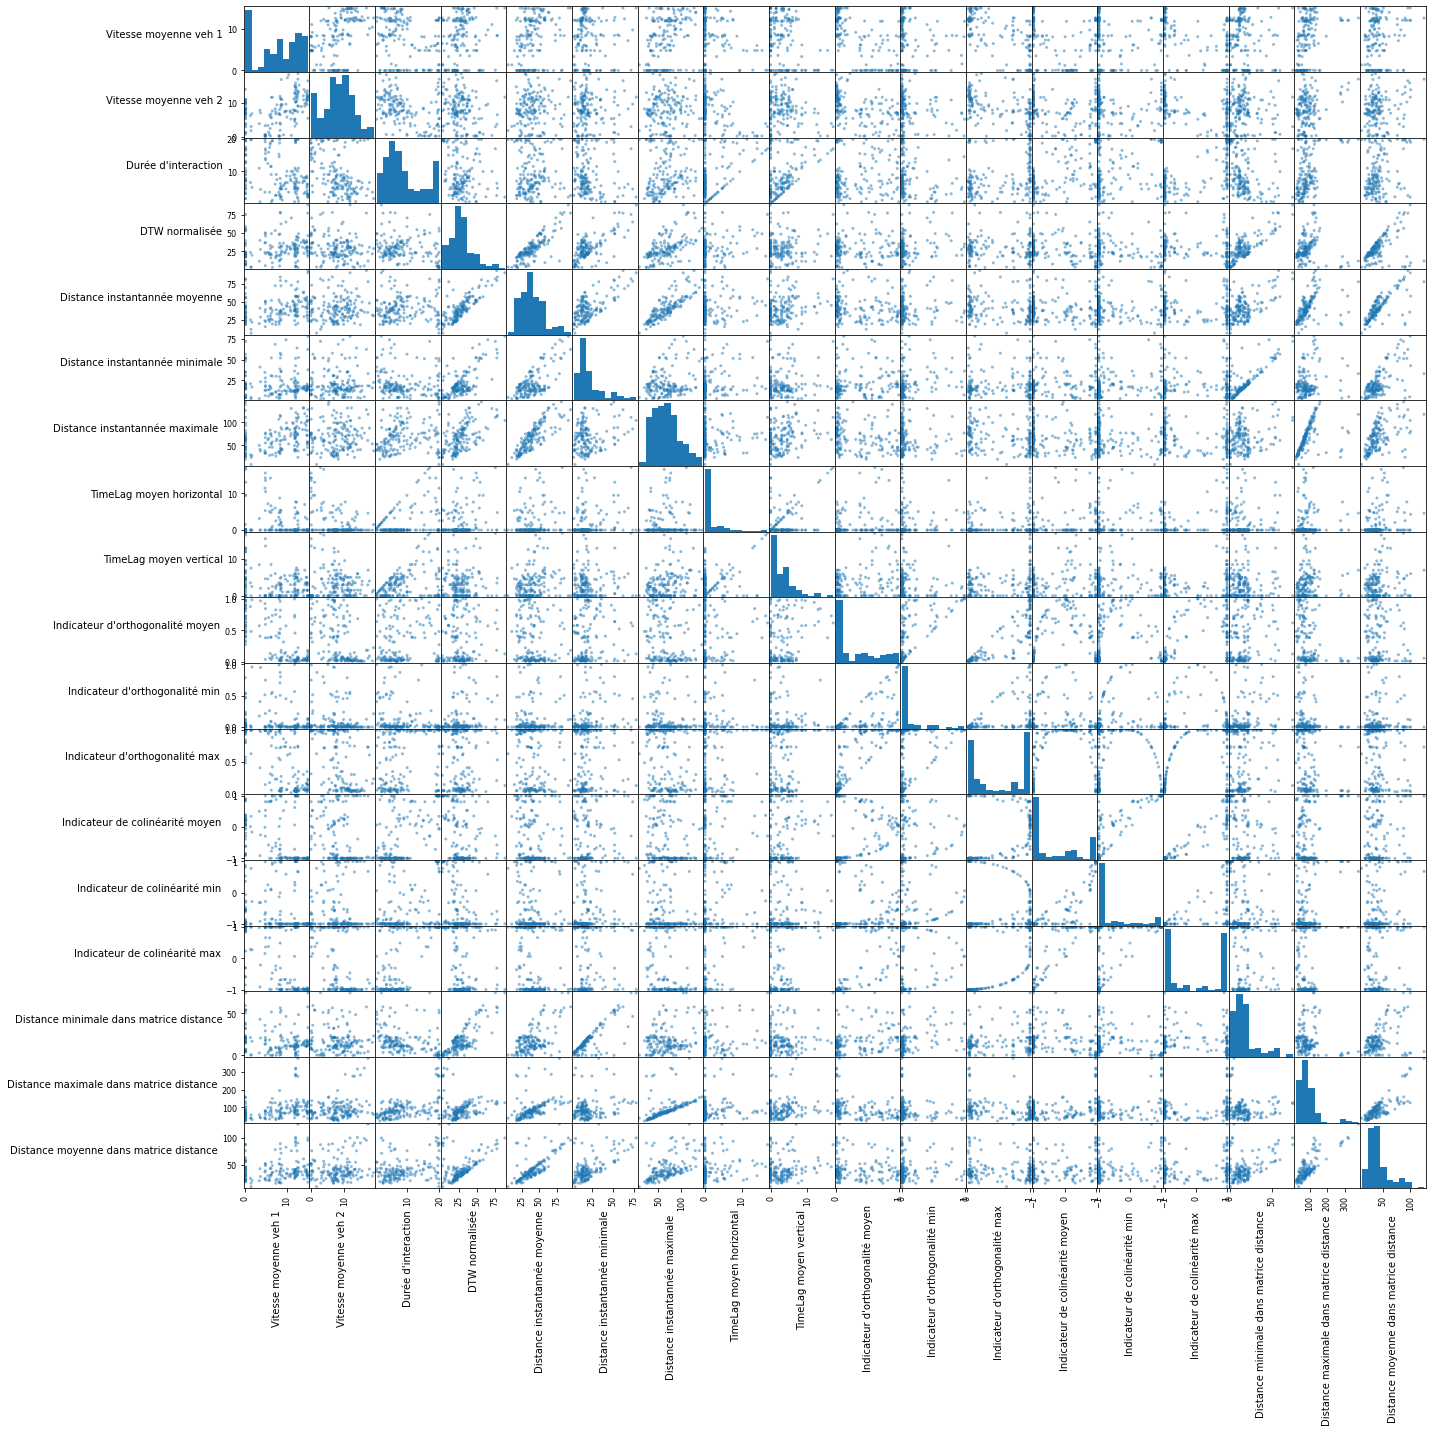

In [218]:
## On va tracer les courbes des colonnes les unes par rapport aux autres, 

# On converti le type des colonnes en float d'abbord
DF_finale[list(DF_finale.columns[3:])] = DF_finale[list(DF_finale.columns[3:])].apply(pd.to_numeric)
axes = pd.plotting.scatter_matrix(DF,figsize=(20,20))
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

plt.tight_layout()
plt.gcf().subplots_adjust(wspace=0, hspace=0)
plt.show()